In [31]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)
library(Hmisc)
library(boot)
require(lme4)

source("../../../spydr_scripts/functions/get_os.R")

theme_set(theme_grey(base_size = 22)) 

Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:reshape’:

    expand

The following object is masked from ‘package:tidyr’:

    expand



In [4]:
os <- get_os()
if (os == 'linux'){home <- '/home/krista/'
} else if(os == 'osx'){home <- '/Users/krista/'}

agg_data_path = paste0(home,'Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/')
setwd(agg_data_path)

In [5]:
clean_df <- read_csv('clean_df.csv',col_types = cols())

(n_subjects = length(unique(clean_df$ID)))
(n_conditions = length(unique(clean_df$condition)))

head(clean_df)

n_e_trials = 10 
theme_set(theme_grey(base_size = 22)) 

[1] 24

[1] 4

LR_choice obs_LR_accuracy obs_LR_solution reward cumulative_reward rt       
1 1         0               0               0      599               0.7115700
2 1         0               0               0      598               0.6814098
3 0         1               0               2      599               0.7671180
4 1         0               0               0      598               0.5072088
5 1         1               1               2      599               0.6562591
6 0         0               1               0      598               0.3423209
  total_trial_time iti       cp_with_slow_fast obs_cp_with_slow_fast ⋯
1 2.385458         0.6701990 1                 0                     ⋯
2 1.939019         0.2597073 0                 1                     ⋯
3 2.498060         0.7406146 0                 0                     ⋯
4 1.742433         0.2502416 0                 0                     ⋯
5 2.350417         0.7001898 0                 0                     ⋯
6 1.831150         0.4982311 0                 1                     ⋯
  epoch_trial shifted_epoch_trial max_epoch_n repeat_trial prop_112 
1 0           0                   25          1            0.3142857
2 1           1                   25          2            0.3142857
3 2           2                   25          3            0.3142857
4 3           3                   25          4            0.3142857
5 4           4                   25          5            0.3142857
6 5           5                   25          6            0.3142857
  n_epoch_trials p_id_solution obs_low_val_cue id_choice p_id_accuracy
1 35             111           111             111       1            
2 35             111           112             112       0            
3 35             111           112             111       1            
4 35             111           112             112       0            
5 35             111           112             111       1            
6 35             111           111             111       1

In [6]:
table(clean_df$ID)
table(clean_df$condition)


 761  762  763  764  765  766  767  768  769  770  771  772  773  774  775  776 
2345 2351 2357 2361 2383 2369 2377 2378 2365 2345 2369 2372 2354 2371 2386 2341 
 777  778  779  780  781  782  783  784 
2347 2356 2386 2372 2374 2349 2357 2377 


   hc    hv    lc    lv 
14267 13889 14267 14319 

In [154]:
unrewarded_trials_idx = which(clean_df$reward == 0)
rewarded_trials_idx = which(clean_df$reward > 0)

unrewarded_NEXT_trials = unrewarded_trials_idx + 1
rewarded_NEXT_trials = rewarded_trials_idx + 1

In [153]:
explore_df = clean_df[rewarded_NEXT_trials,]
current_ID_choice = clean_df[unrewarded_trials_idx, 'id_choice']

In [150]:
explore_df['id_choice_NEXT_trial'] = clean_df[rewarded_NEXT_trials, 'id_choice']
explore_df['id_choice_NEXT_trial'] = clean_df[rewarded_NEXT_trials, 'id_choice']

explore_df['id_low_val_choice_NEXT_trial']= clean_df[rewarded_NEXT_trials, 'obs_low_val_cue']

explore_df['exploratory_choice'] = as.logical(id_choice_NEXT_trial == id_low_val_choice_NEfXT_trial)*1

#if it doesn't equal the choice on the previous trial 
explore_df['exploratory_choice'] = as.logical(current_ID_choice != id_choice_NEXT_trial)*1

In [34]:
table(explore_df$exploratory_choice, explore_df$cond)

Warning message:
“Unknown or uninitialised column: 'cond'.”

ERROR: Error in table(explore_df$exploratory_choice, explore_df$cond): all arguments must have the same length


In [81]:
seq(1,nrow(n_epoch_trials))

ERROR: Error in nrow(n_epoch_trials): object 'n_epoch_trials' not found


In [85]:
names(explore_df)

[1] "LR_choice"                    "obs_LR_accuracy"             
 [3] "obs_LR_solution"              "reward"                      
 [5] "cumulative_reward"            "rt"                          
 [7] "total_trial_time"             "iti"                         
 [9] "cp_with_slow_fast"            "obs_cp_with_slow_fast"       
[11] "obs_high_val_cue"             "ID"                          
[13] "condition"                    "coded_condition"             
[15] "original_trial"               "epoch_n"                     
[17] "epoch_trial"                  "shifted_epoch_trial"         
[19] "max_epoch_n"                  "repeat_trial"                
[21] "prop_112"                     "n_epoch_trials"              
[23] "p_id_solution"                "obs_low_val_cue"             
[25] "id_choice"                    "p_id_accuracy"               
[27] "id_choice_NEXT_trial"         "id_low_val_choice_NEXT_trial"
[29] "exploratory_choice"

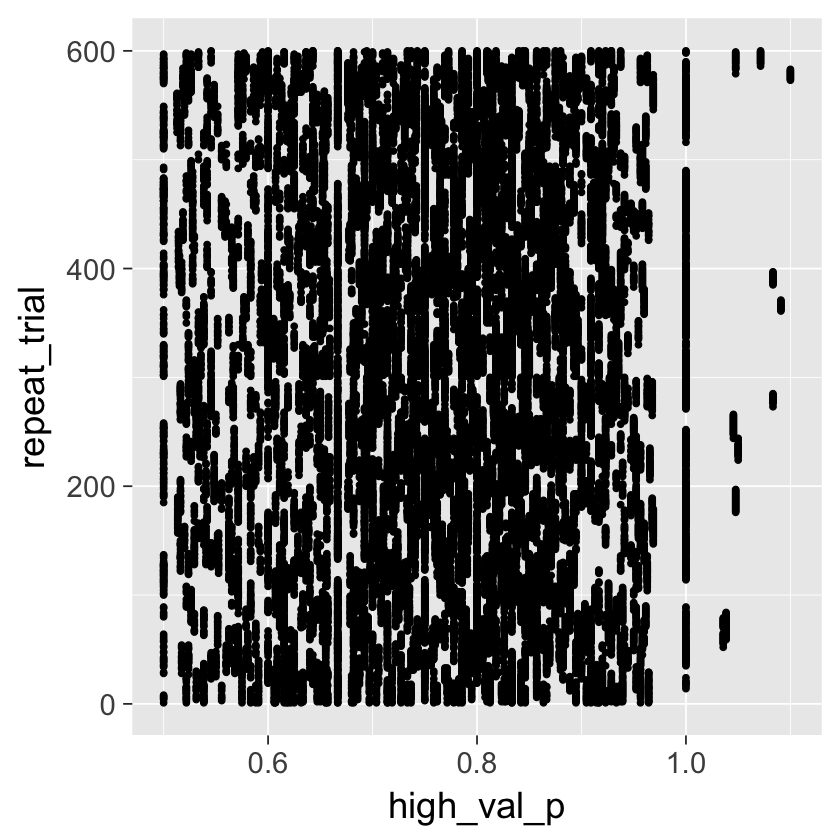

In [124]:
ggplot(explore_df_no_na, aes(high_val_p, repeat_trial)) + geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


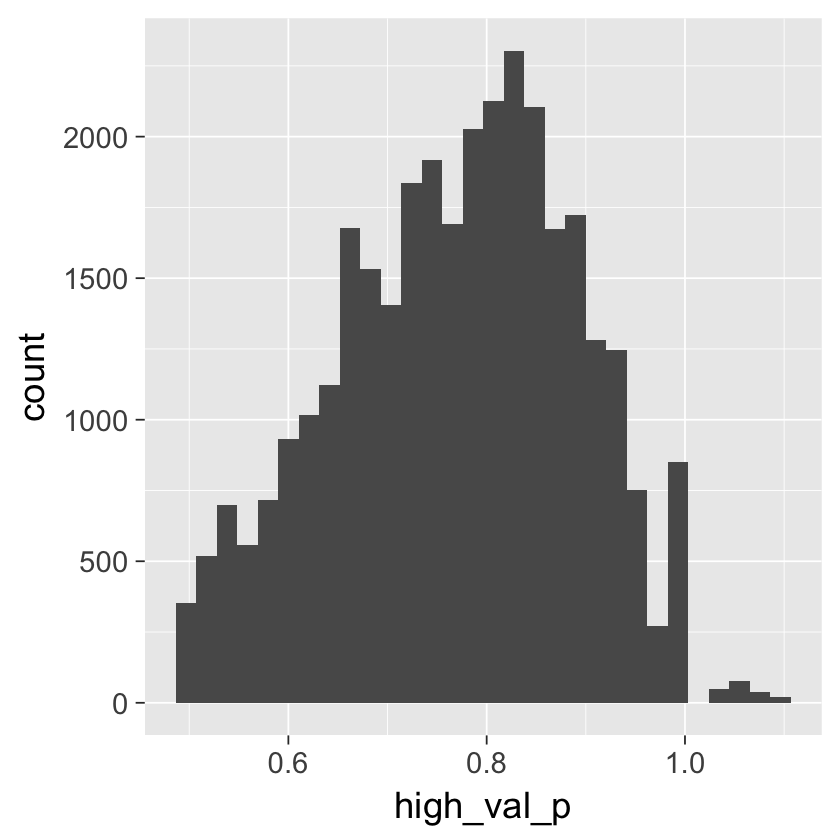

In [122]:
ggplot(explore_df_no_na, aes(high_val_p)) + geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

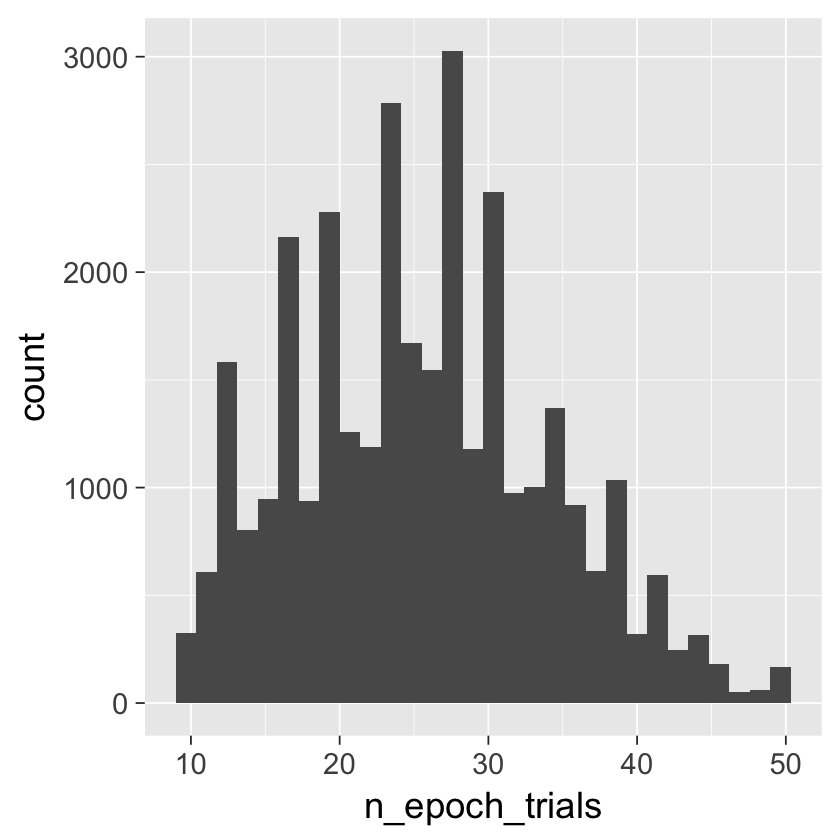

In [94]:
ggplot(explore_df, aes(n_epoch_trials)) + geom_histogram()

In [111]:
explore_df_no_na['high_val_p'] = ifelse(explore_df_no_na$prop_112 < 0.5, 1-explore_df_no_na$prop_112, explore_df_no_na$prop_112)

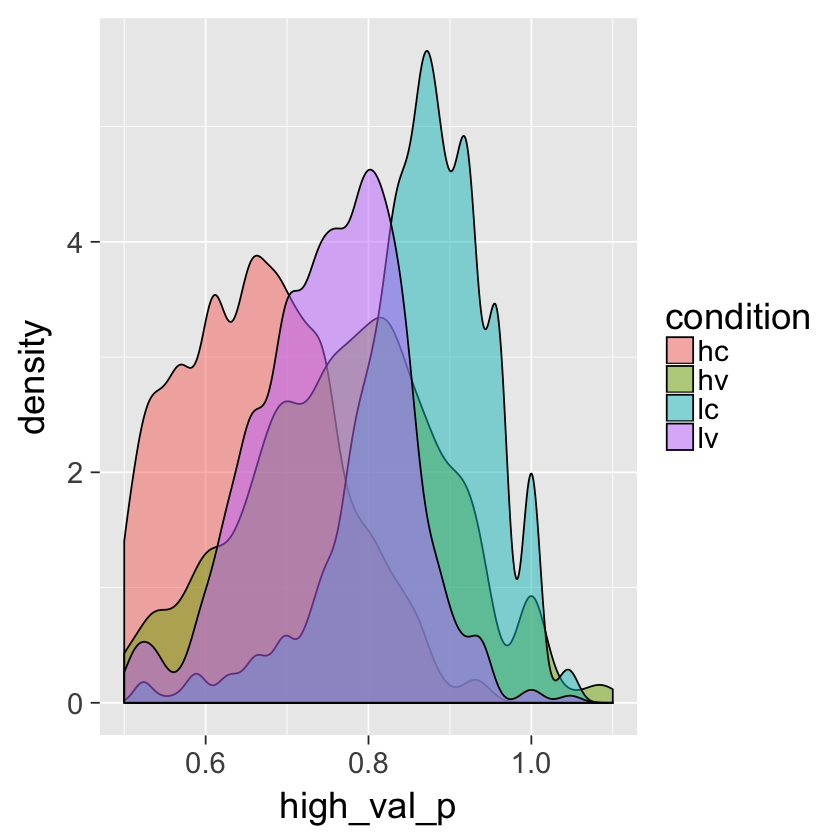

In [120]:
ggplot(explore_df_no_na, aes(high_val_p, fill=condition)) + geom_density(alpha=0.5)

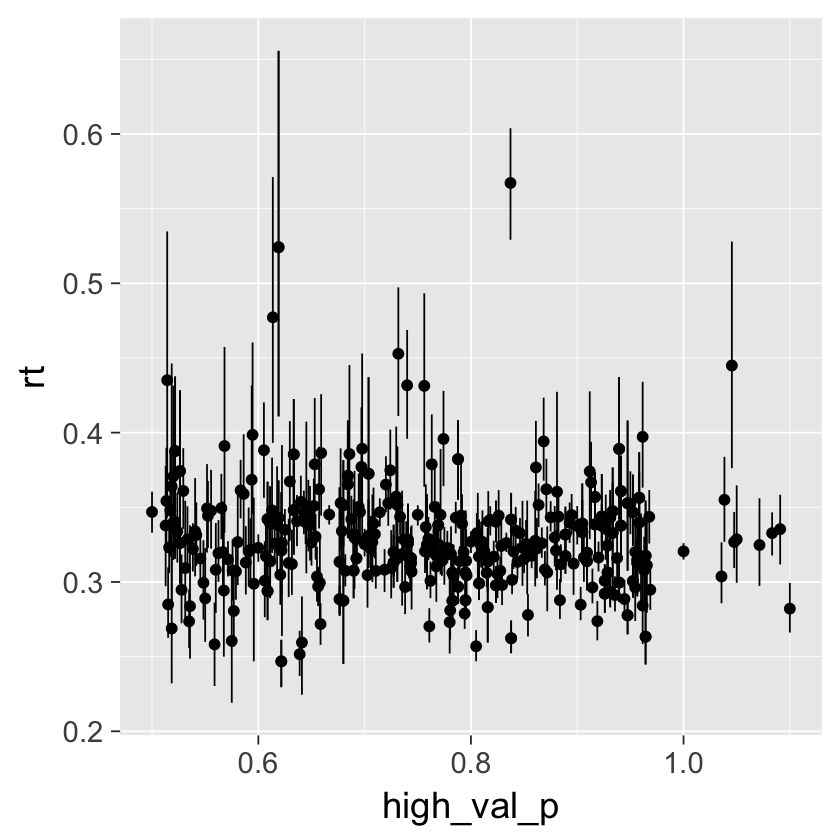

In [116]:
ggplot(explore_df_no_na, aes(high_val_p, rt)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(), size = .5) 

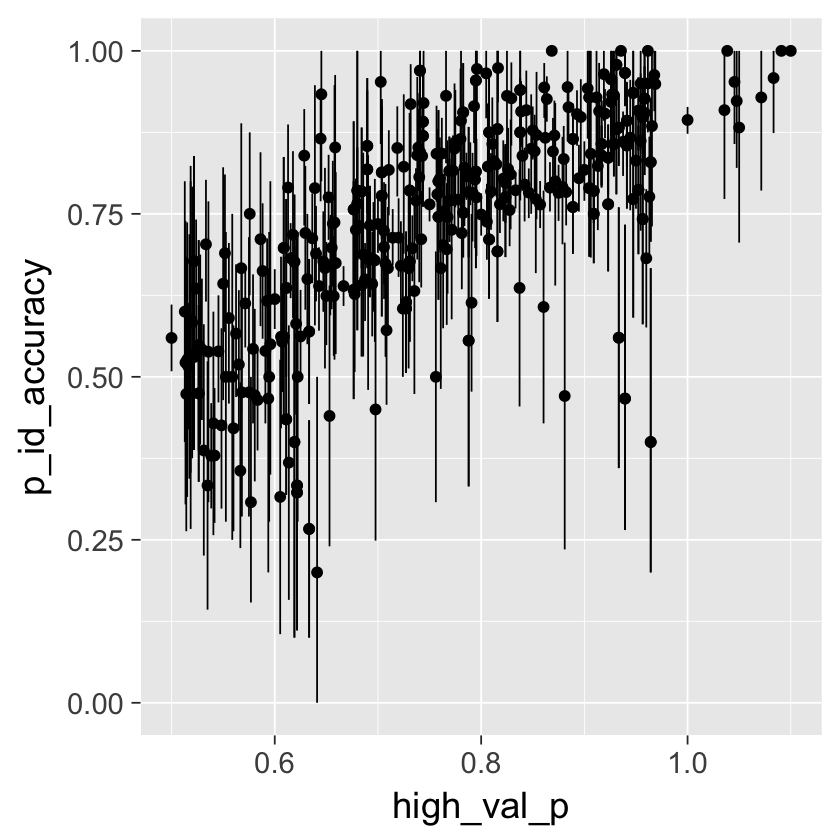

In [115]:
ggplot(explore_df_no_na, aes(high_val_p, p_id_accuracy)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(), size = .5) 

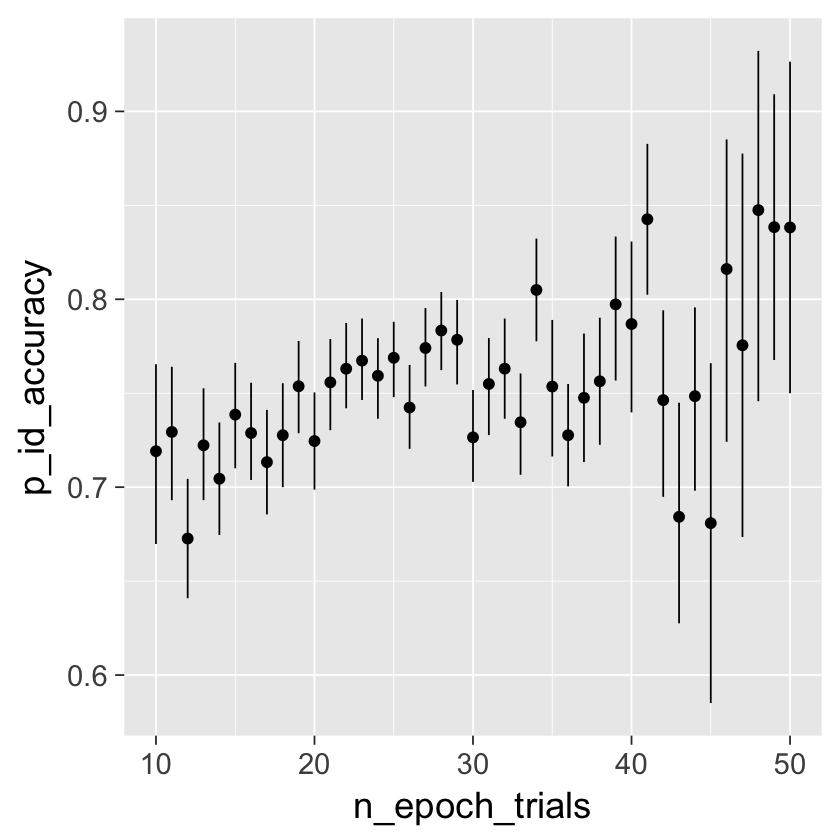

In [105]:
ggplot(explore_df_no_na, aes(n_epoch_trials, p_id_accuracy)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(), size = .5) 

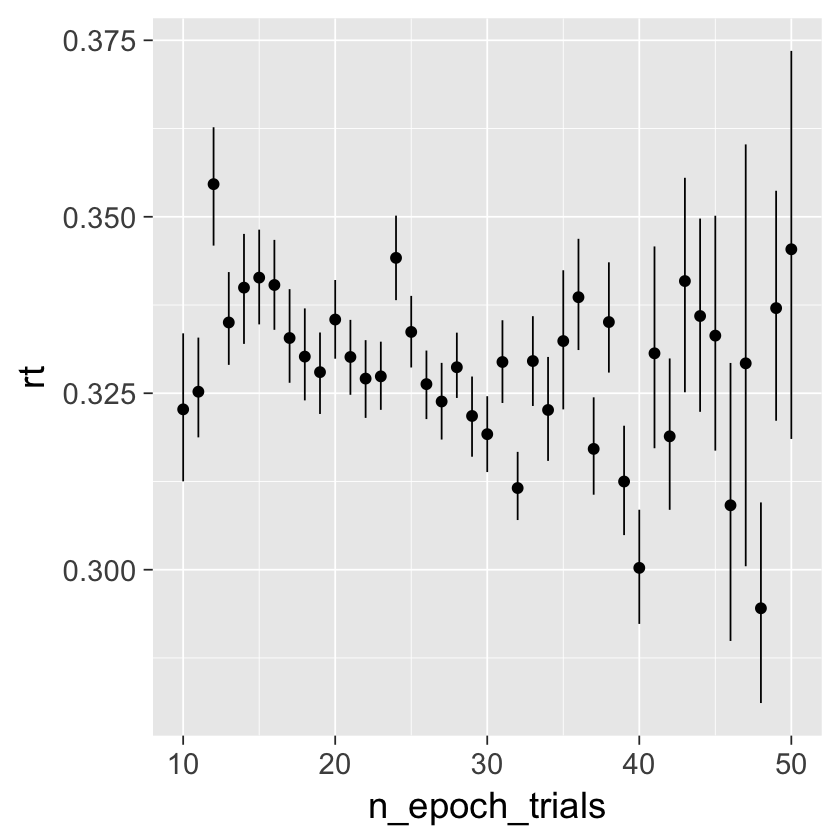

In [104]:
ggplot(explore_df_no_na, aes(n_epoch_trials, rt)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(), size = .5) 

Warning message:
“Removed 1 rows containing missing values (geom_point).”

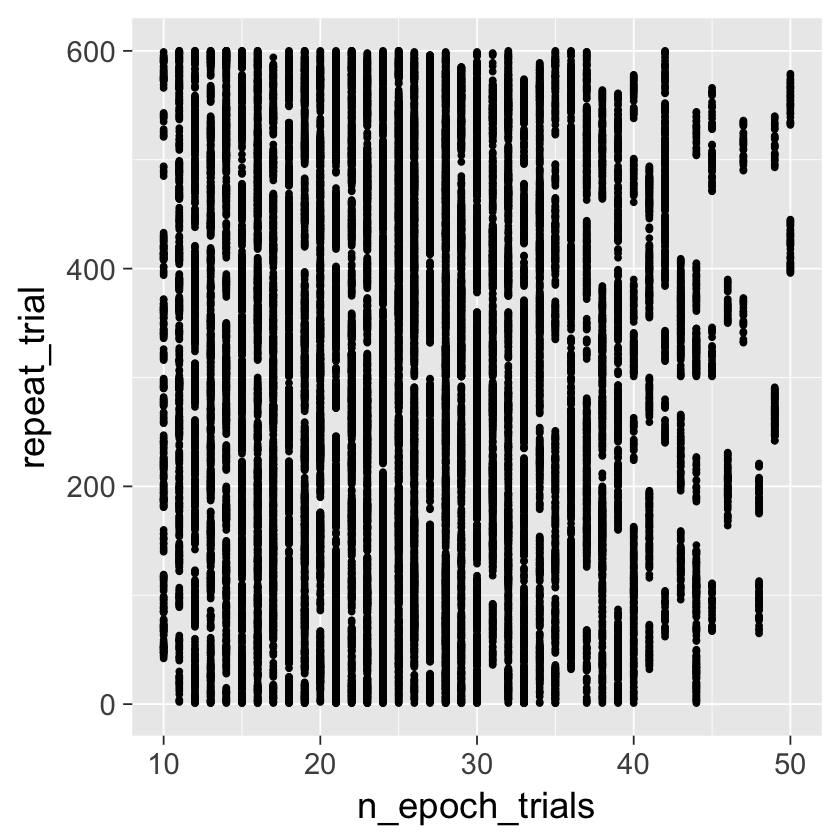

In [90]:
ggplot(explore_df, aes(n_epoch_trials, repeat_trial)) + geom_point()

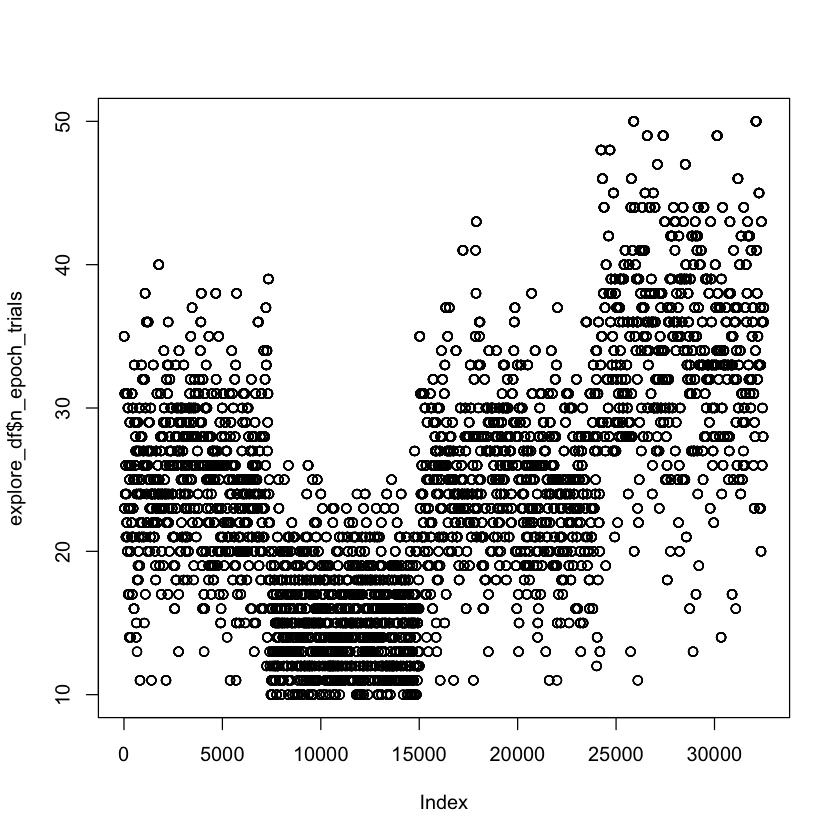

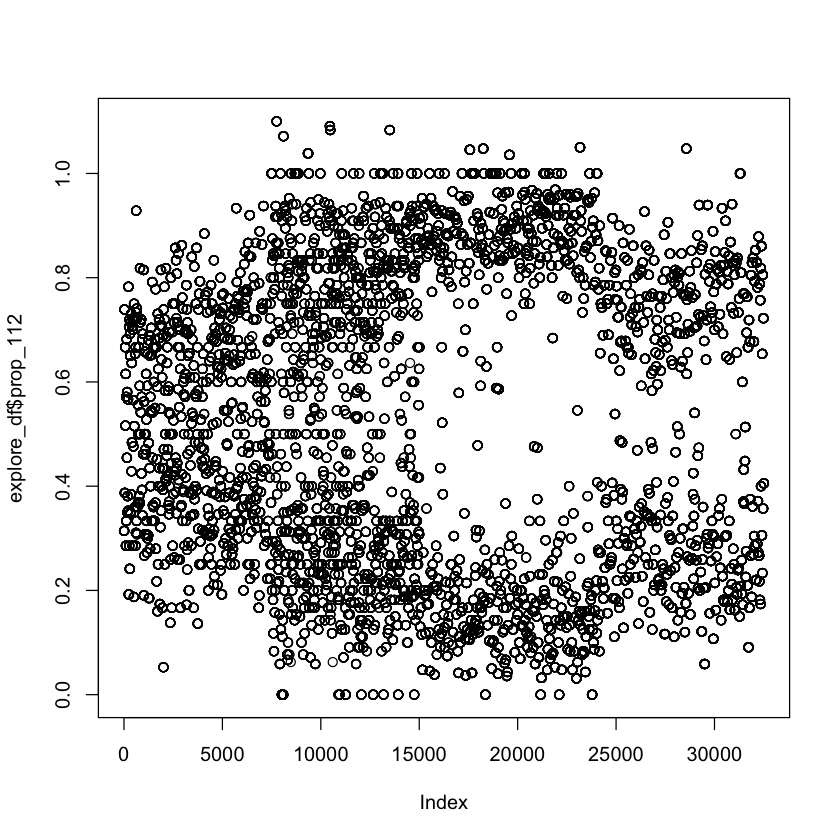

In [74]:
plot(explore_df$n_epoch_trials); 
plot(explore_df$prop_112)

In [155]:
rt_glmer = lmer(rt ~ scale(high_val_p)*scale(n_epoch_trials) + (1|ID),  data=explore_df_no_na)
anova(rt_glmer)
confint(rt_glmer, method='boot')

Df Sum Sq      Mean Sq     F value   
scale(high_val_p)                       1  0.058569619 0.058569619  6.1233532
scale(n_epoch_trials)                   1  0.566031443 0.566031443 59.1776160
scale(high_val_p):scale(n_epoch_trials) 1  0.002196858 0.002196858  0.2296778

Computing bootstrap confidence intervals ...


In [ ]:
#redo this with observed values of conflict and vol
B_glmer = lmer(ideal_B ~ scale(high_val_p)*scale(n_epoch_trials) + (1|ID), data=explore_df_no_na)
summary(B_glmer)
confint(B_glmer, method='boot')

In [157]:
#redo this with observed values of conflict and vol
cpp_glmer = lmer(cpp ~ scale(high_val_p)*scale(n_epoch_trials) + (1|ID), data=explore_df_no_na)
summary(cpp_glmer)
confint(cpp_glmer, method='boot')

ERROR: Error in eval(predvars, data, env): object 'cpp' not found


In [156]:
#redo this with observed values of conflict and vol
acc_glmer = glmer(p_id_accuracy ~ scale(high_val_p)*scale(n_epoch_trials) + (1|ID), family='binomial', data=explore_df_no_na)
summary(acc_glmer)
confint(acc_glmer, method='boot')

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: p_id_accuracy ~ scale(high_val_p) * scale(n_epoch_trials) + (1 |  
    ID)
   Data: explore_df_no_na

     AIC      BIC   logLik deviance df.resid 
 33394.2  33436.2 -16692.1  33384.2    32509 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2435  0.2357  0.4208  0.5685  1.7527 

Random effects:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 0.2756   0.525   
Number of obs: 32514, groups:  ID, 24

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                              1.19097    0.10802   11.02  < 2e-16
scale(high_val_p)                        0.50291    0.01413   35.59  < 2e-16
scale(n_epoch_trials)                    0.15885    0.01420   11.19  < 2e-16
scale(high_val_p):scale(n_epoch_trials)  0.07371    0.01510    4.88 1.05e-06
                                        

Computing bootstrap confidence intervals ...


In [146]:
explore_glmer = glmer(exploratory_choice ~ scale(high_val_p)*scale(n_epoch_trials) + (1|ID), family='binomial', data=explore_df_no_na)
summary(explore_glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: exploratory_choice ~ scale(high_val_p) * scale(n_epoch_trials) +  
    (1 | ID)
   Data: explore_df_no_na

     AIC      BIC   logLik deviance df.resid 
 40794.1  40836.1 -20392.1  40784.1    32509 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7899 -0.7405 -0.5736  1.0905  2.4150 

Random effects:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 0.0527   0.2296  
Number of obs: 32514, groups:  ID, 24

Fixed effects:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -0.570702   0.048375  -11.80   <2e-16
scale(high_val_p)                       -0.451046   0.012476  -36.15   <2e-16
scale(n_epoch_trials)                   -0.107779   0.012111   -8.90   <2e-16
scale(high_val_p):scale(n_epoch_trials) -0.009941   0.013429   -0.74    0.459
                              

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

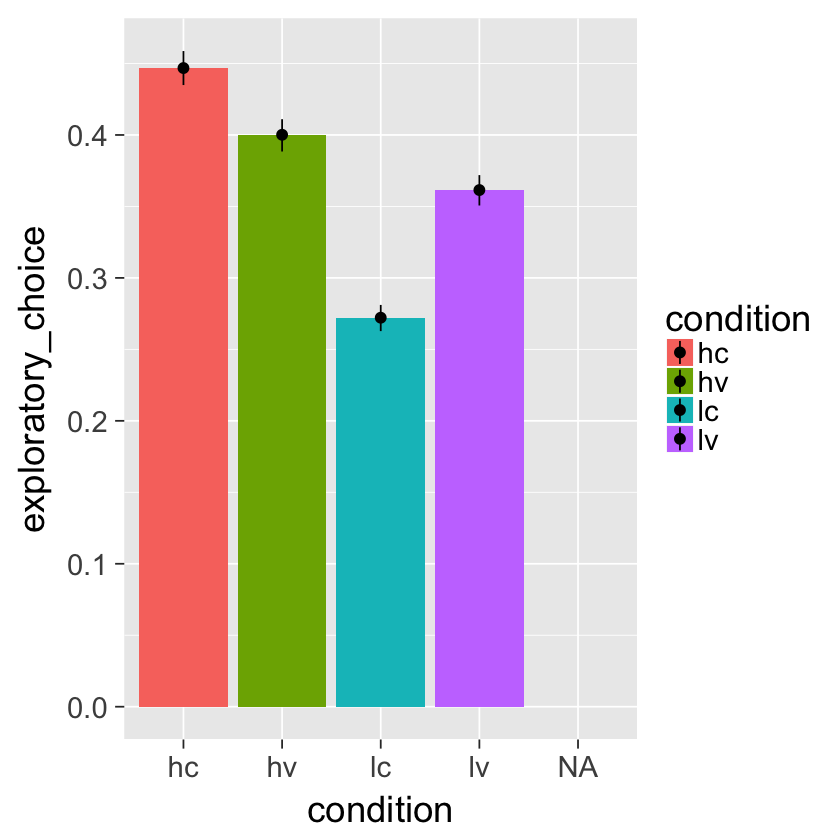

In [28]:
#after rewarded, did people choose another option? 
#measure of exploratory behavior 
ggplot(explore_df, aes(condition, exploratory_choice)) + stat_summary(fun.data = "mean_cl_boot", geom = "bar", aes(fill=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(fill=condition), size = .5)  

In [61]:
explore_df_no_na = na.exclude(explore_df)

In [65]:
explore_df_no_na %>% group_by(condition, ID) %>% summarise(max_epoch_n=max(epoch_n))

condition max_epoch_n
1 hc        26         
2 hv        42         
3 lc        26         
4 lv        19

condition ID  max_epoch_n
1  hc        761 25         
2  hc        762 25         
3  hc        763 26         
4  hc        764 22         
5  hc        765 24         
6  hc        766 24         
7  hc        767 24         
8  hc        768 23         
9  hc        769 26         
10 hc        770 23         
11 hc        771 23         
12 hc        772 23         
13 hc        773 22         
14 hc        774 25         
15 hc        775 26         
16 hc        776 25         
17 hc        777 25         
18 hc        778 24         
19 hc        779 25         
20 hc        780 26         
21 hc        781 25         
22 hc        782 26         
23 hc        783 25         
24 hc        784 23         
25 hv        761 40         
26 hv        762 40         
27 hv        763 37         
28 hv        764 40         
29 hv        765 38         
30 hv        766 39         
⋮  ⋮         ⋮   ⋮          
67 lc        779 25         
68 lc        780 26         
69 lc        781 25         
70 lc        782 26         
71 lc        783 25         
72 lc        784 23         
73 lv        761 17         
74 lv        762 18         
75 lv        763 18         
76 lv        764 19         
77 lv        765 18         
78 lv        766 18         
79 lv        767 16         
80 lv        768 18         
81 lv        769 18         
82 lv        770 19         
83 lv        771 17         
84 lv        772 17         
85 lv        773 18         
86 lv        774 18         
87 lv        775 18         
88 lv        776 18         
89 lv        777 18         
90 lv        778 18         
91 lv        779 18         
92 lv        780 18         
93 lv        781 18         
94 lv        782 17         
95 lv        783 17         
96 lv        784 18

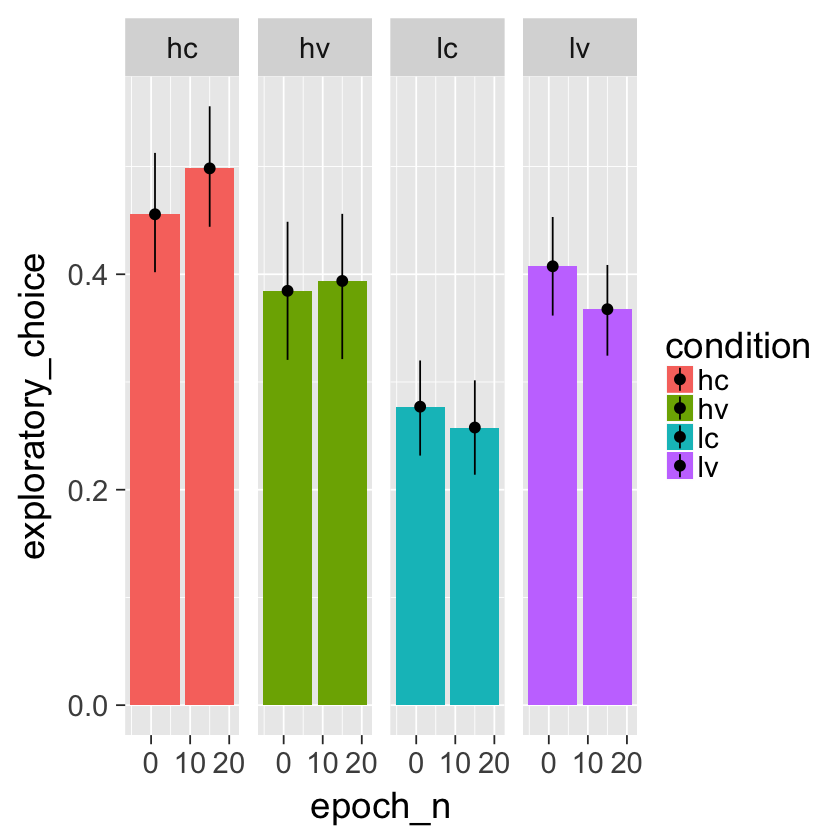

In [70]:
#how did this evolve over epochs?
ggplot(subset(explore_df, (epoch_n == 1 | epoch_n == 15)), aes(epoch_n, exploratory_choice)) + stat_summary(fun.data = "mean_cl_boot", geom = "bar", aes(fill=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(fill=condition), size = .5) + facet_grid(.~condition)

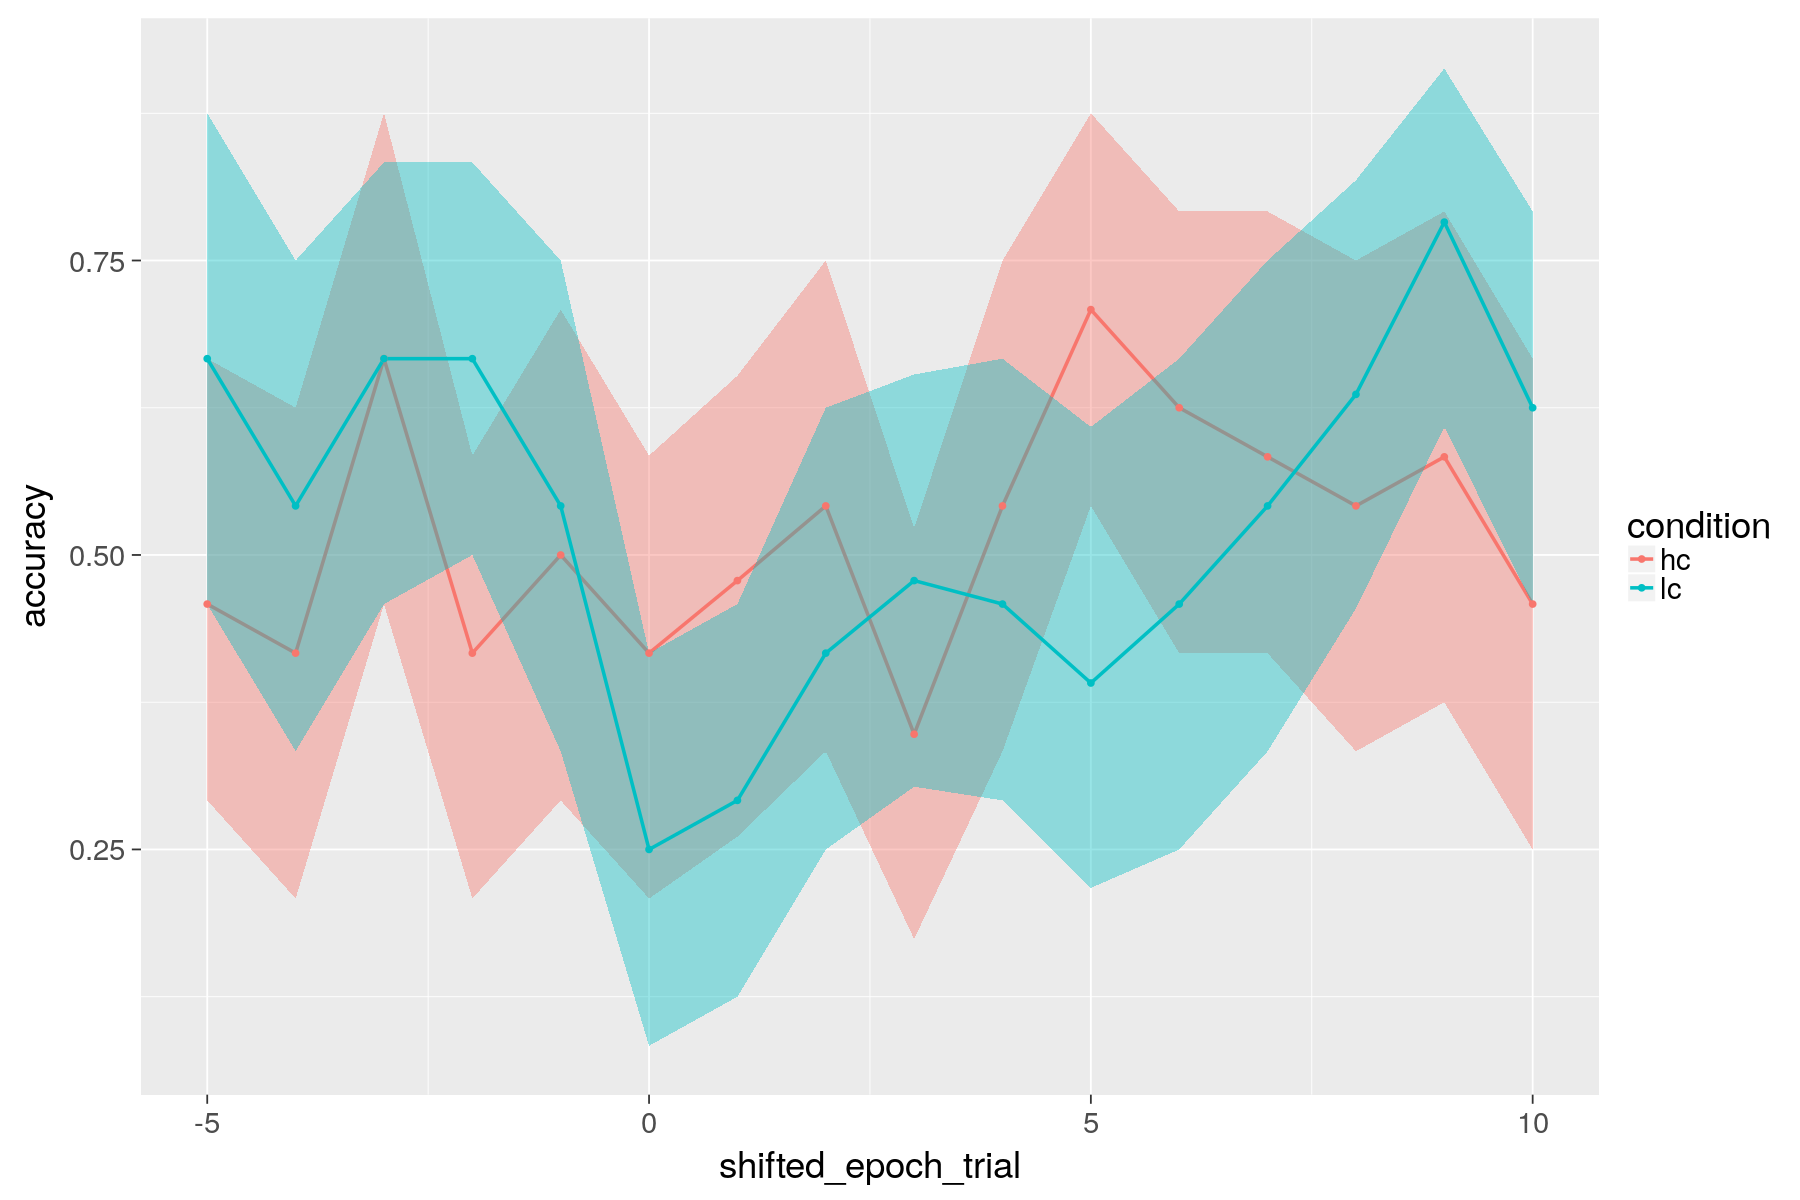

In [32]:

options(repr.plot.width=15, repr.plot.height=10)

ggplot(subset(clean_df, epoch_n == 2 & (condition=='lc' | condition == 'hc') & shifted_epoch_trial <= n_e_trials & max_e_trial >=n_e_trials), aes(shifted_epoch_trial, accuracy, color=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "smooth", aes(fill=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "point", aes(fill=condition)) 

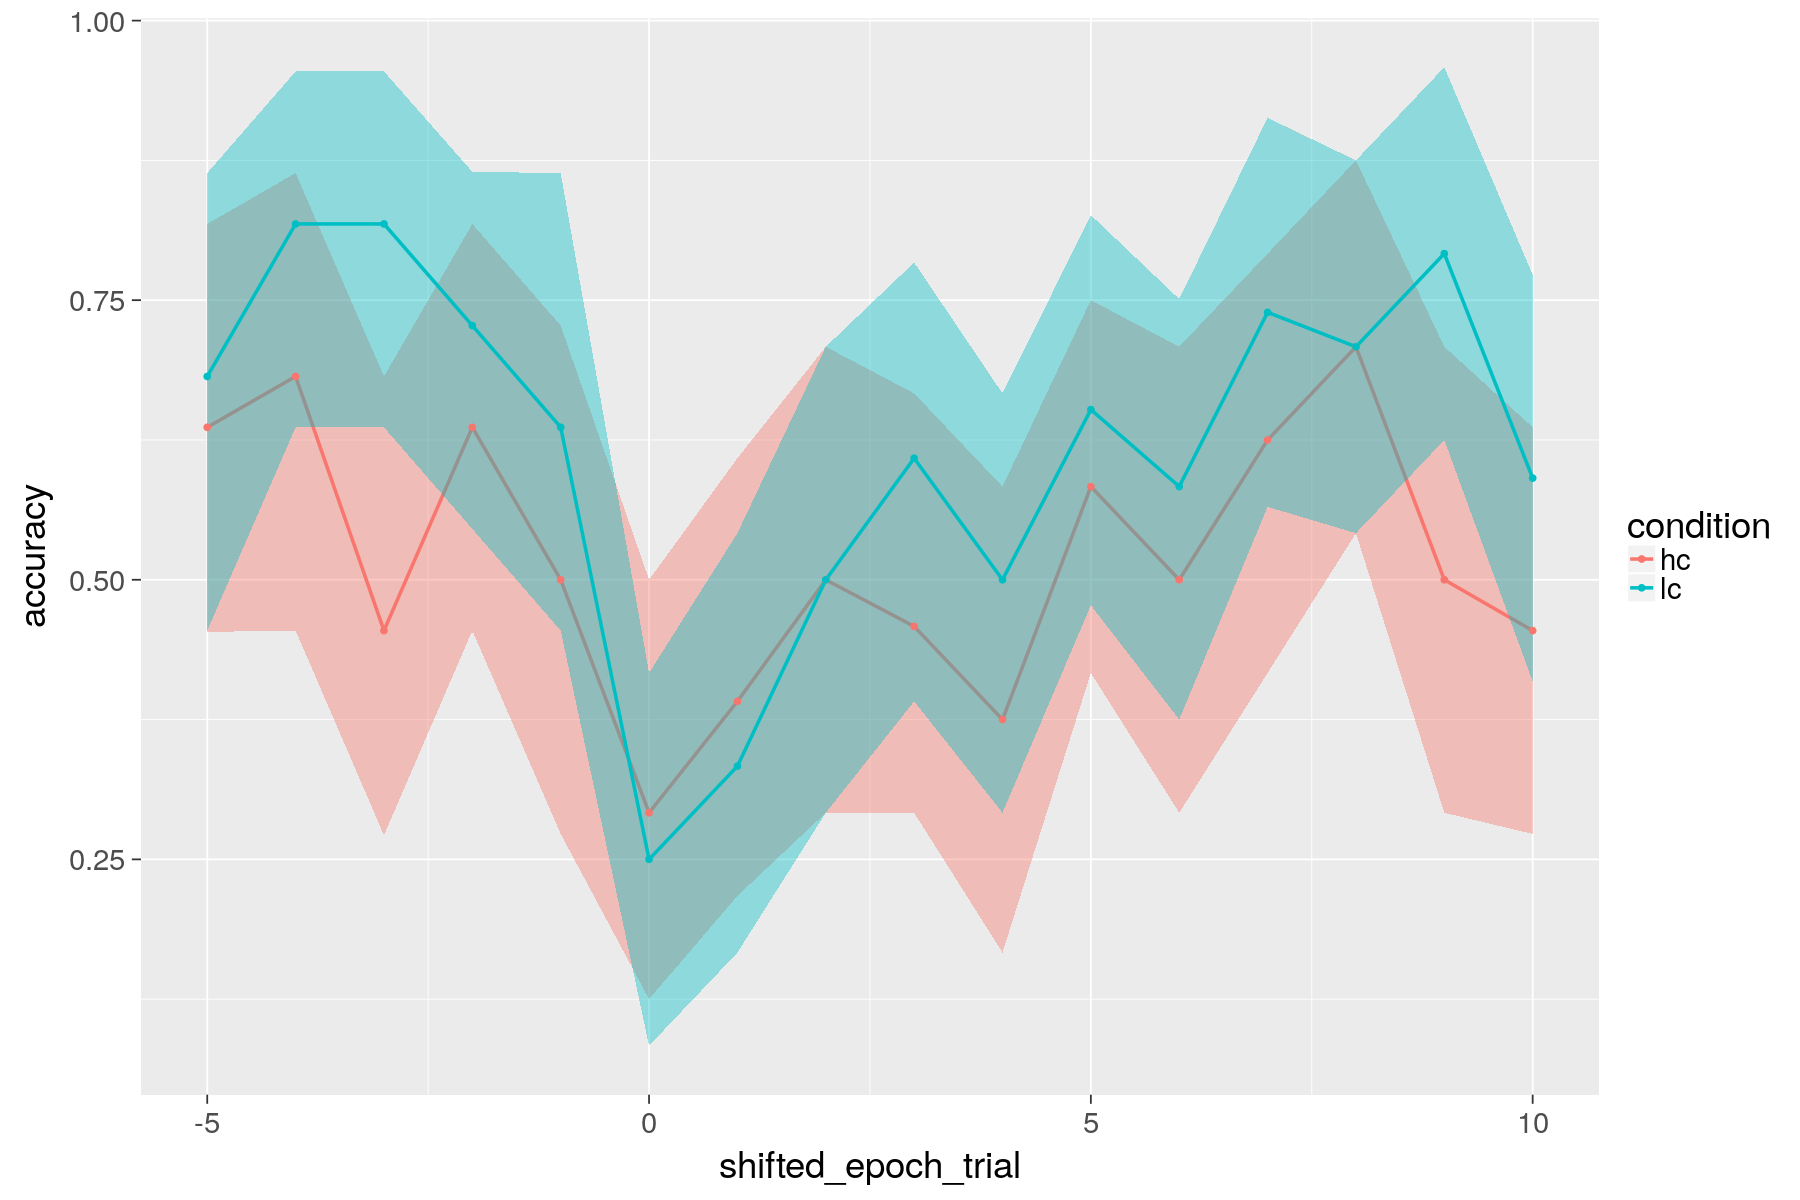

In [33]:
ggplot(subset(clean_df, epoch_n == 22 & (condition=='lc' | condition == 'hc') & shifted_epoch_trial <= n_e_trials & max_e_trial >=n_e_trials), aes(shifted_epoch_trial, accuracy, color=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "smooth", aes(fill=condition)) + stat_summary(fun.data = "mean_cl_boot", geom = "point", aes(fill=condition)) 

In [34]:
max_epoch_n <- clean_df %>% 
group_by(condition,ID) %>% summarise(epoch_n = max(epoch_n)) %>% summarise(min(epoch_n))
max_epoch_n

condition min(epoch_n)
1 hc        22          
2 hv        37          
3 lc        22          
4 lv        16

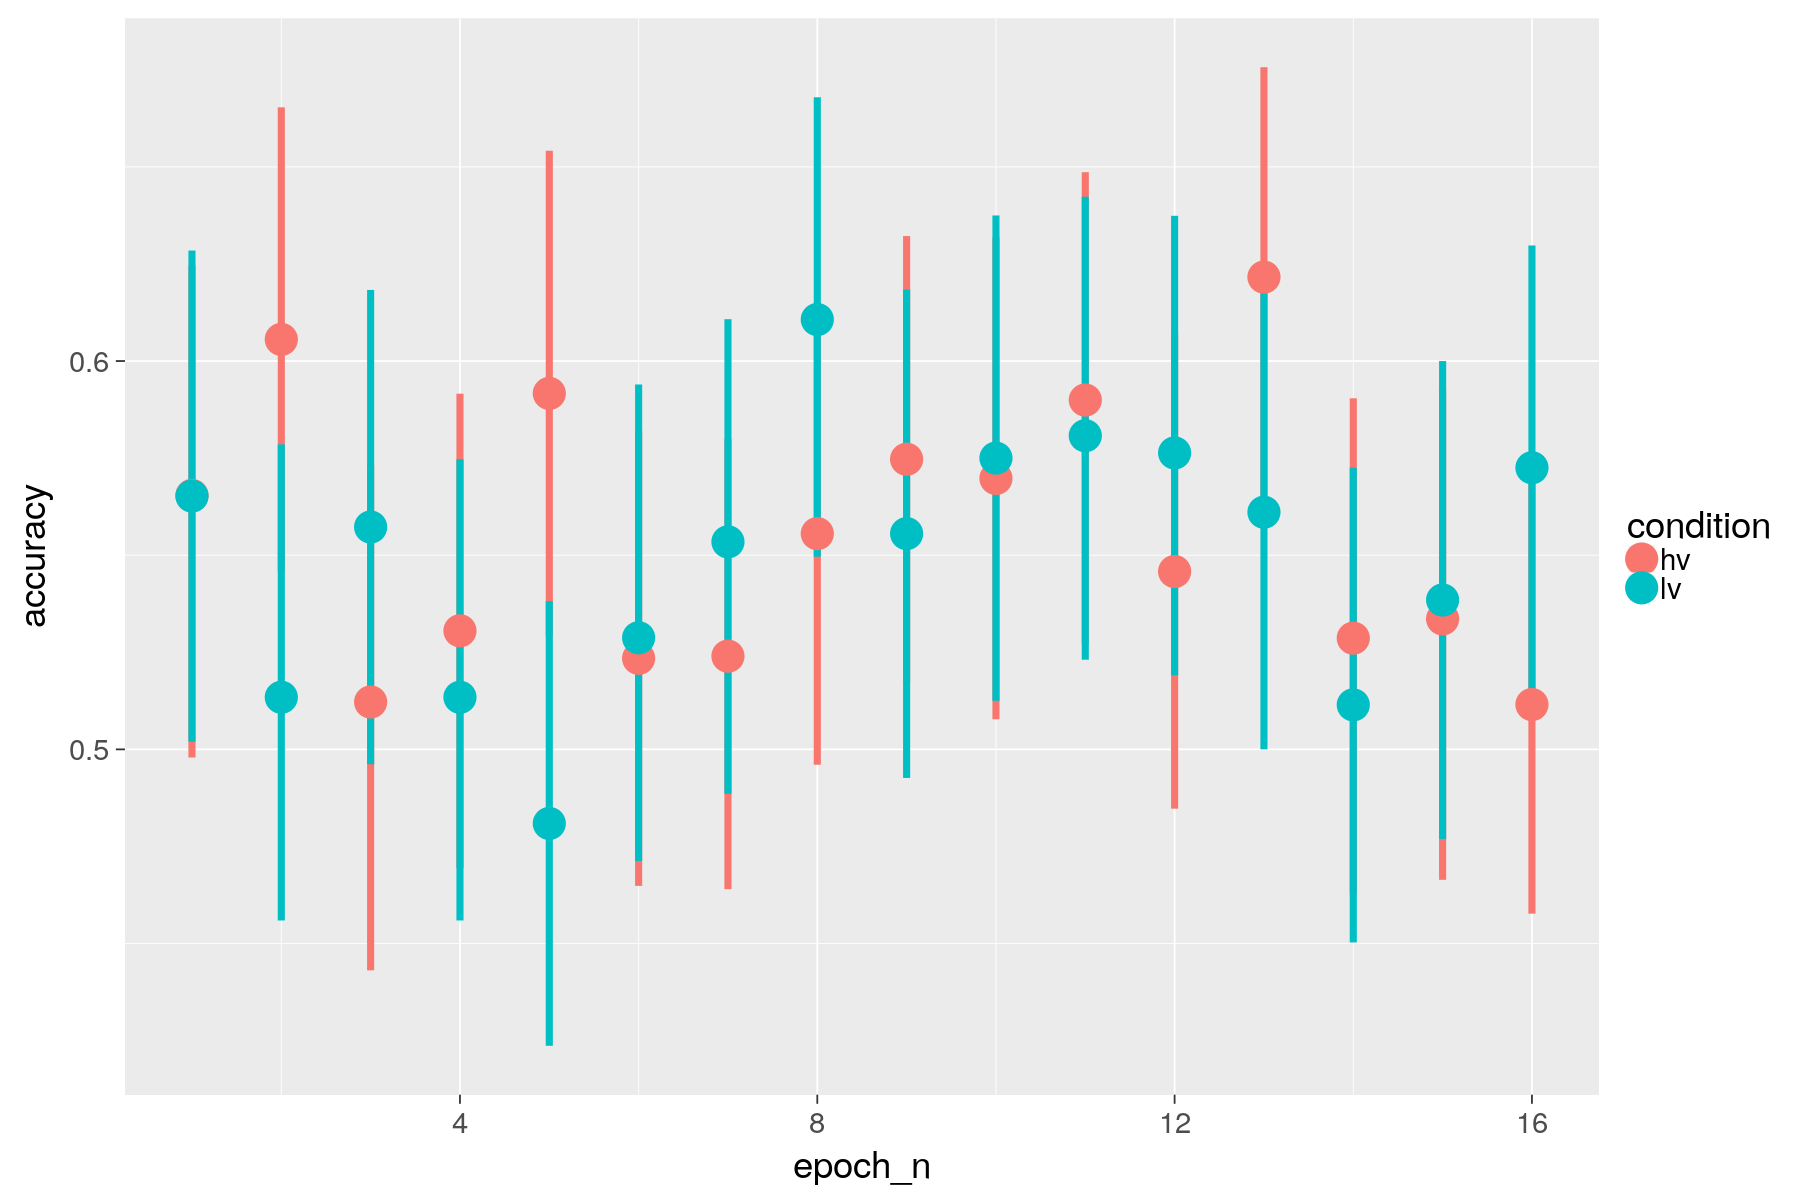

In [35]:
options(repr.plot.width=15, repr.plot.height=10)

ggplot(subset(clean_df, max_e_trial >= n_e_trials & epoch_trial <= n_e_trials & epoch_n <= 16 & (condition=='lv' | condition == 'hv') & shifted_epoch_trial <= n_e_trials & max_e_trial >=n_e_trials), aes(epoch_n, accuracy, color=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(fill=condition), size = 2) 

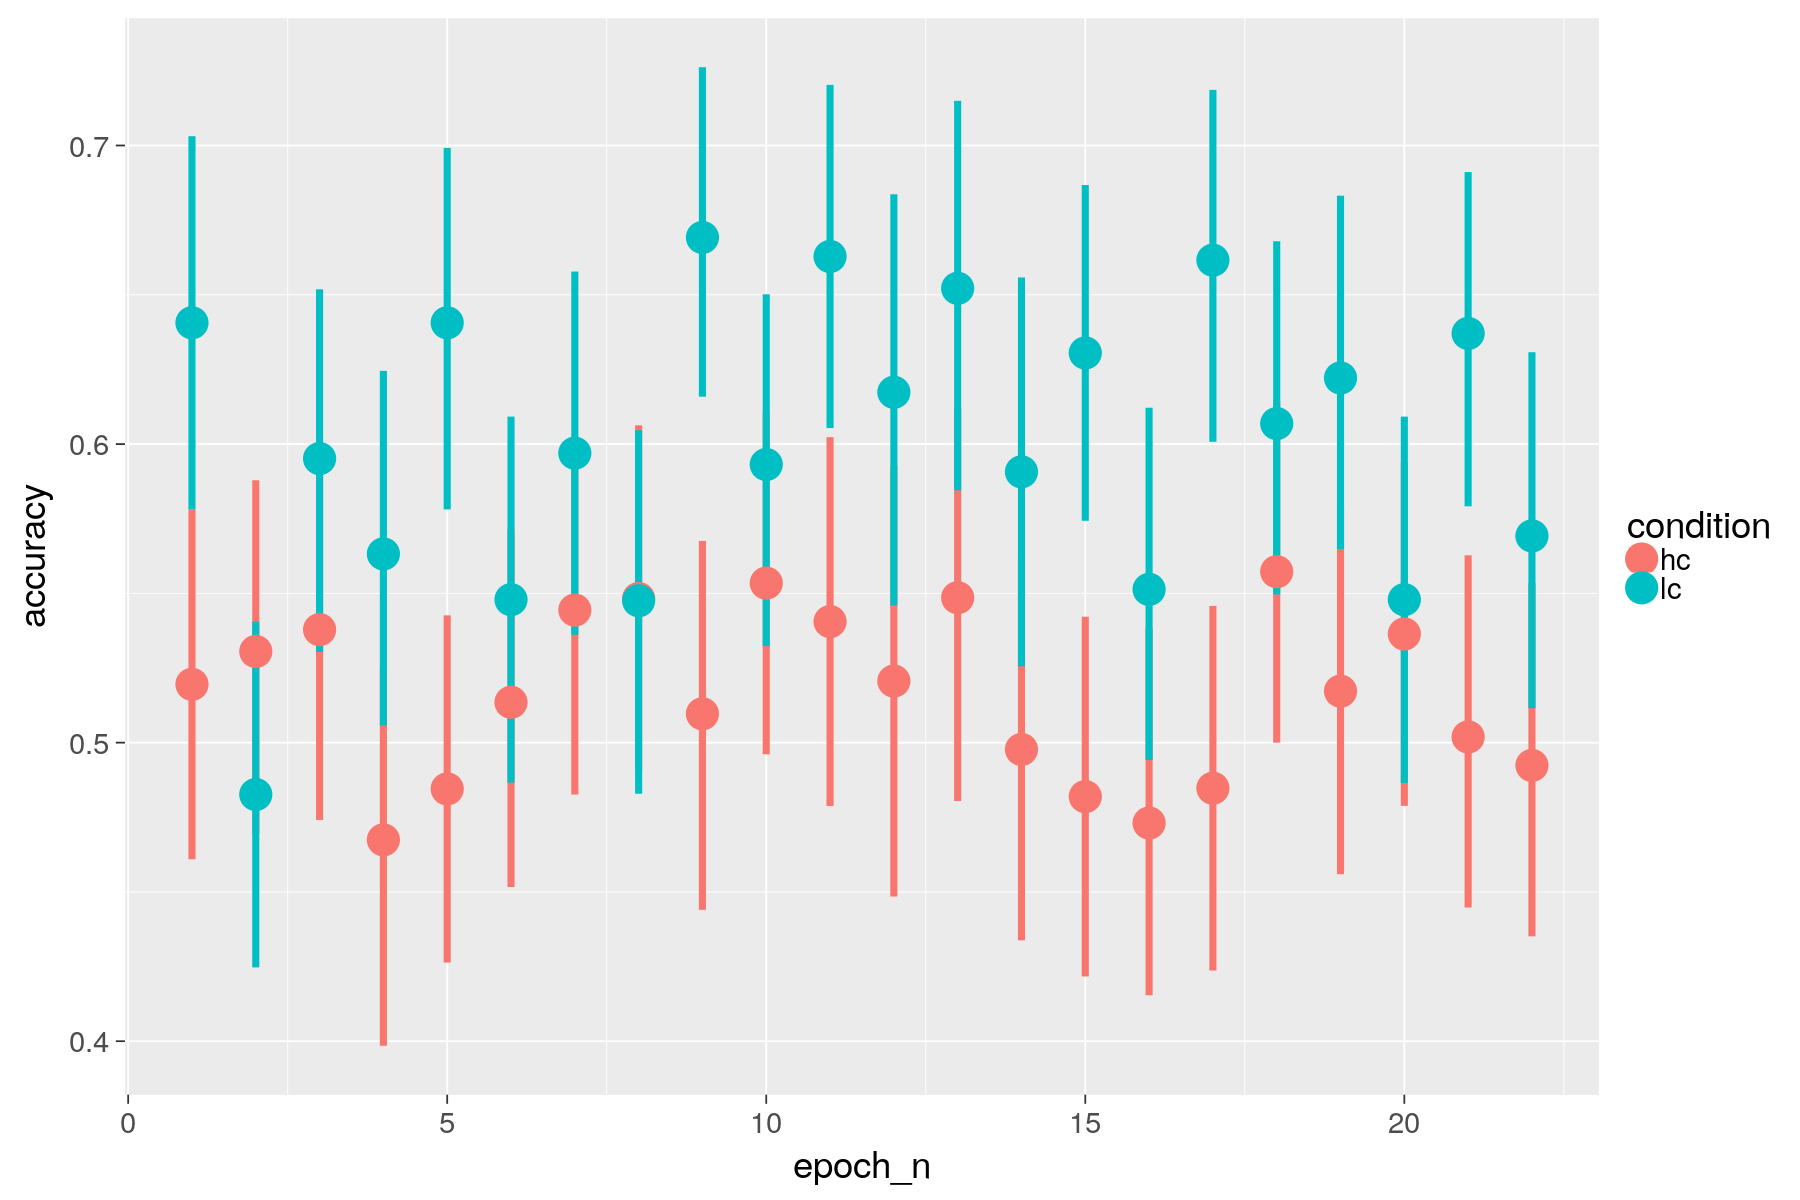

In [36]:
options(repr.plot.width=15, repr.plot.height=10)

ggplot(subset(clean_df, max_e_trial >= n_e_trials & epoch_trial <= n_e_trials & epoch_n <= 22 & (condition=='lc' | condition == 'hc') & shifted_epoch_trial <= n_e_trials & max_e_trial >=n_e_trials), aes(epoch_n, accuracy, color=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "pointrange", aes(fill=condition), size = 2) 

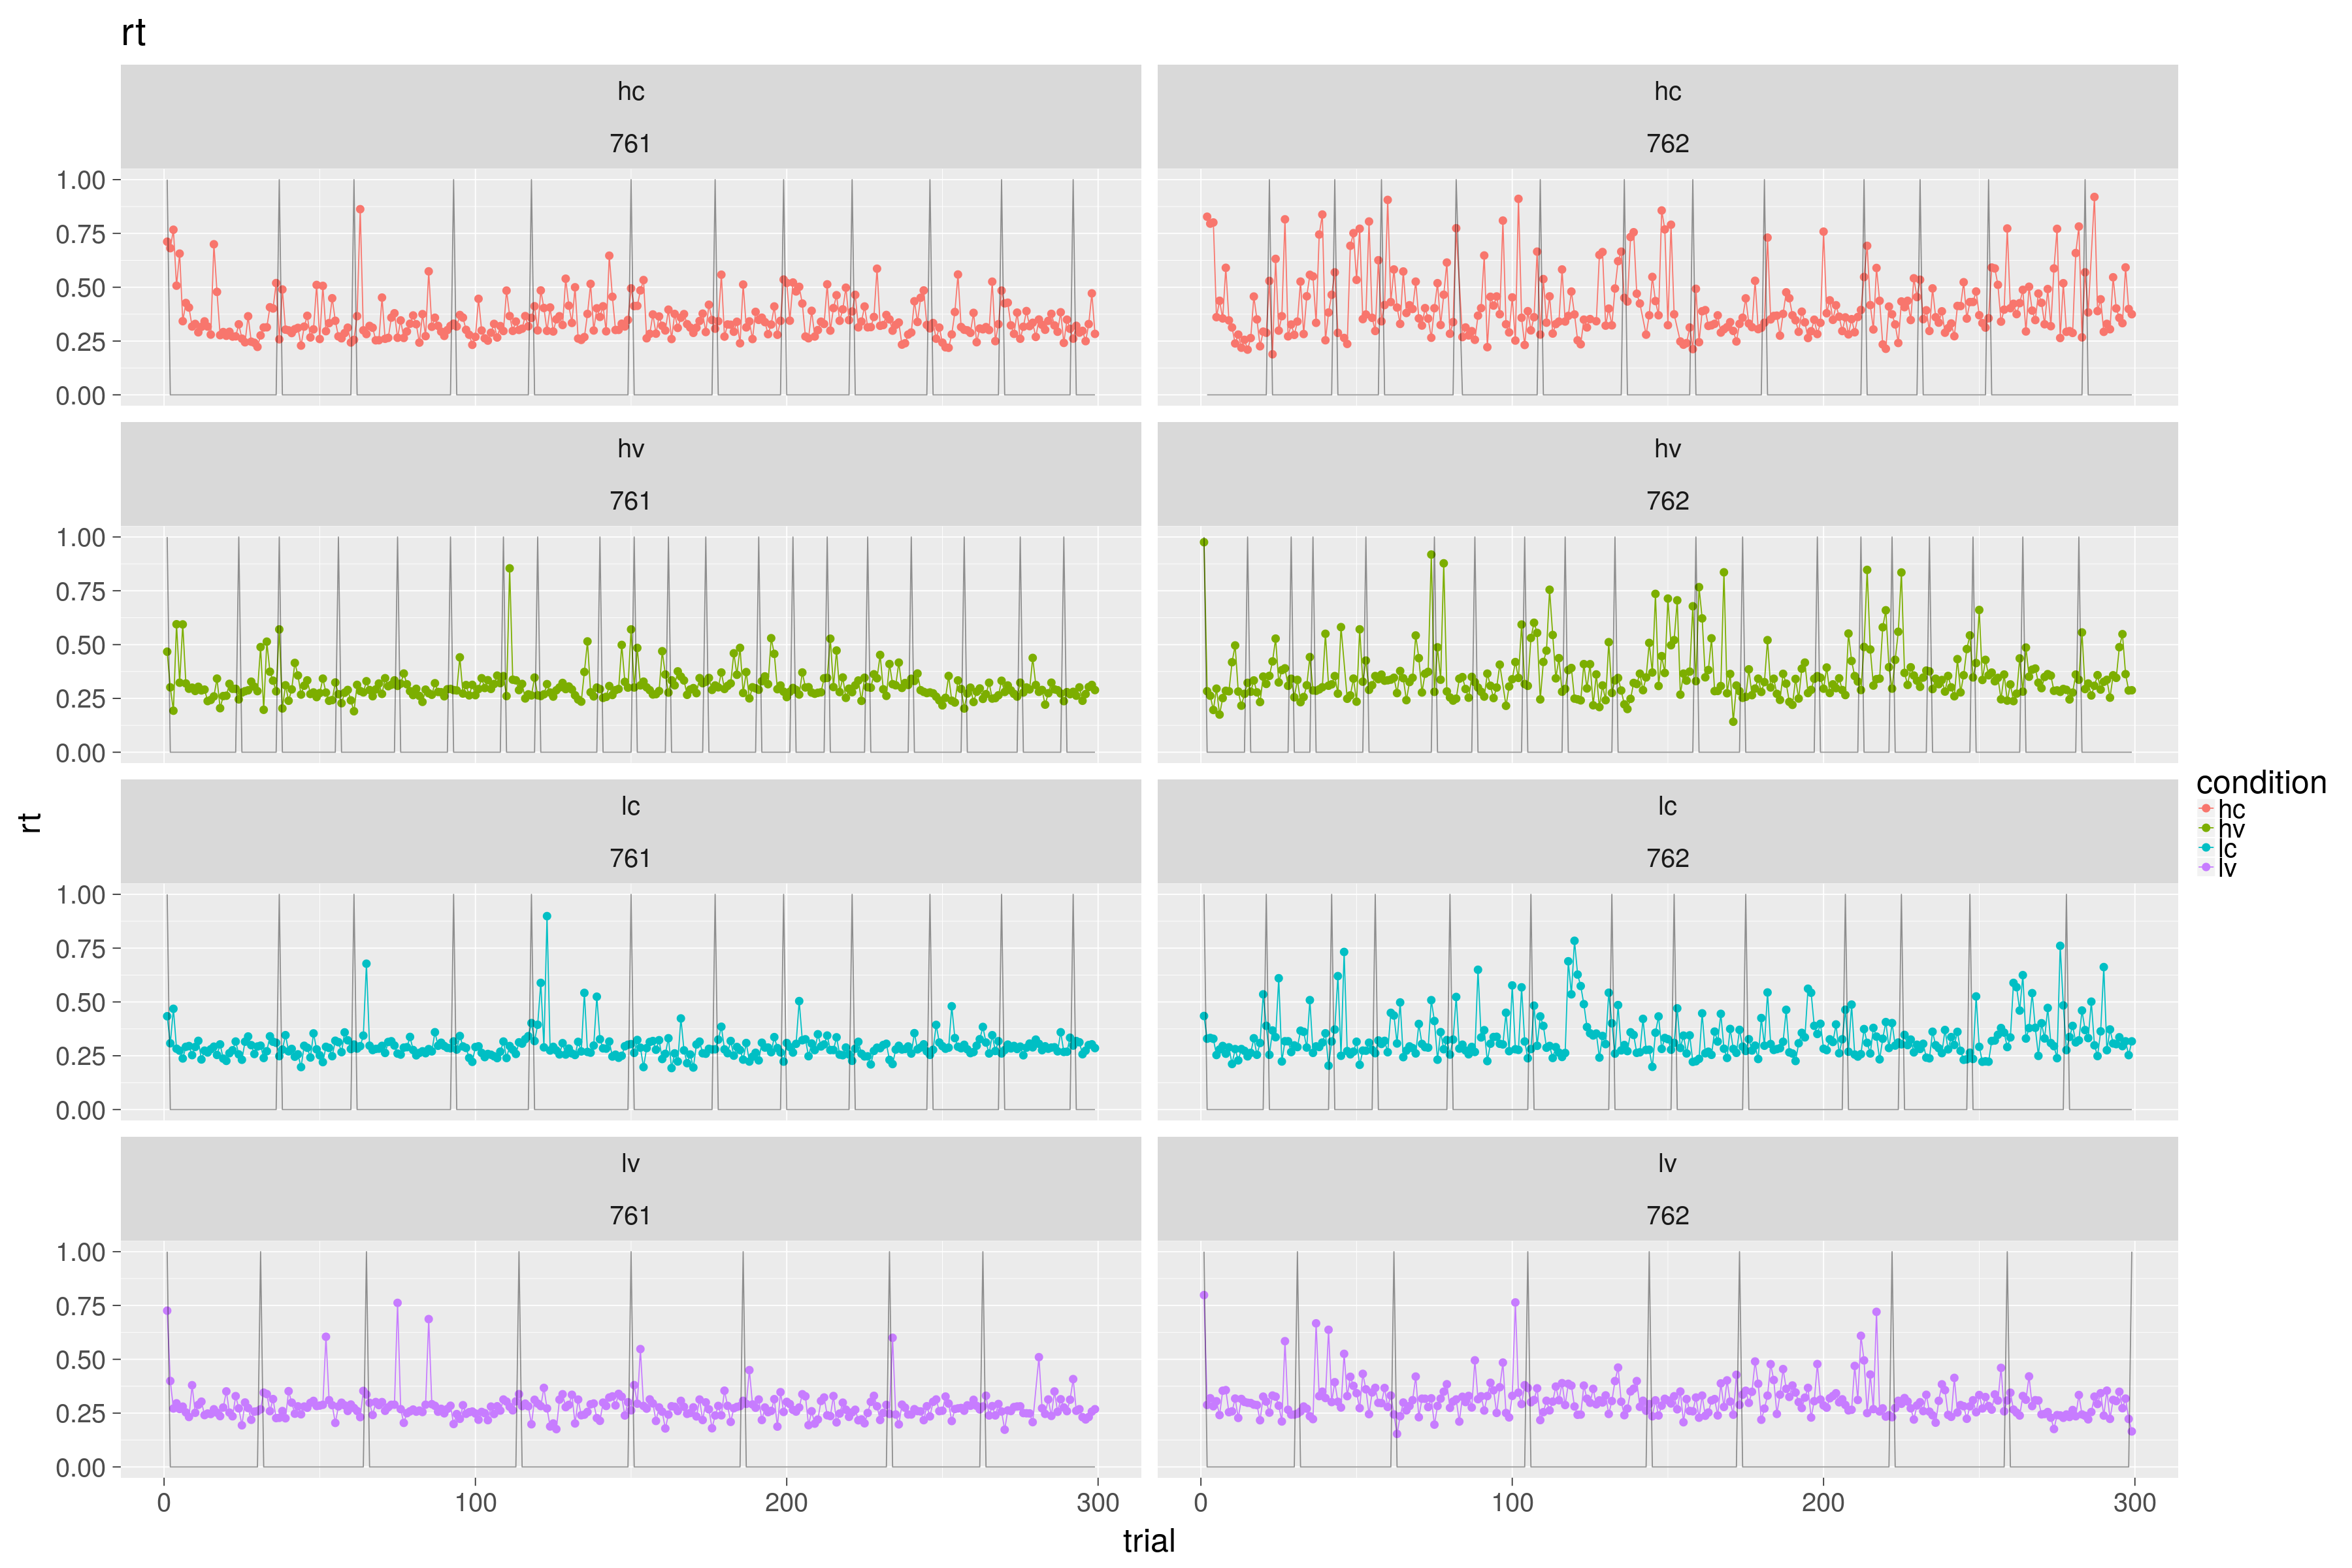

In [41]:
options(repr.plot.width=30, repr.plot.height=20)
theme_set(theme_grey(base_size = 30)) 

ggplot(subset(clean_df, ID < 763 & trial < 300), aes(trial, rt, color=condition)) +
    geom_point(size=3) + geom_line() + facet_wrap( condition ~ ID, nrow=4) + ggtitle('rt') + geom_line(aes(trial,cp_with_slow_fast), color='black', alpha=0.4)

In [42]:
epoch_rate_df <- subset(clean_df, max_e_trial >= n_e_trials & shifted_epoch_trial <= n_e_trials & shifted_epoch_trial > -2)


epoch_rate_df_mu <- epoch_rate_df %>% group_by(condition, shifted_epoch_trial, epoch_n) %>% summarise(mu_acc=mean(accuracy))

epoch_rate_df_mu[(epoch_rate_df_mu$shifted_epoch_trial  >= 0), 'adaptation_phase'] <- 1
epoch_rate_df_mu[(epoch_rate_df_mu$shifted_epoch_trial  == -1 | epoch_rate_df_mu$shifted_epoch_trial  == 0) & epoch_rate_df_mu$epoch_n > 1, 'transition_phase'] <- 1

head(epoch_rate_df_mu)

condition shifted_epoch_trial epoch_n mu_acc    adaptation_phase
1 hc        -1                  1       0.5416667 NA              
2 hc        -1                  2       0.5000000 NA              
3 hc        -1                  3       0.5217391 NA              
4 hc        -1                  4       0.3478261 NA              
5 hc        -1                  5       0.5833333 NA              
6 hc        -1                  6       0.5416667 NA              
  transition_phase
1 NA              
2  1              
3  1              
4  1              
5  1              
6  1

In [43]:
lc_transition_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 2 & condition == 'lc'))$coefficients[2]
hc_transition_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 2 & condition == 'hc'))$coefficients[2]
lv_transition_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 2 & condition == 'lv'))$coefficients[2]
hv_transition_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 2 & condition == 'hv'))$coefficients[2]


In [44]:
max_epoch_n

condition min(epoch_n)
1 hc        22          
2 hv        37          
3 lc        22          
4 lv        16

In [45]:
lc_transition_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 22 & condition == 'lc'))$coefficients[2]
hc_transition_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 22 & condition == 'hc'))$coefficients[2]
lv_transition_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 16 & condition == 'lv'))$coefficients[2]
hv_transition_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, transition_phase == 1 & epoch_n == 37 & condition == 'hv'))$coefficients[2]

In [46]:
lc_adaptation_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'lc'))$coefficients[2]
hc_adaptation_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'hc'))$coefficients[2]
lv_adaptation_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'lv'))$coefficients[2]
hv_adaptation_slope_early <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'hv'))$coefficients[2]

lc_adaptation_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 12 & condition == 'lc'))$coefficients[2]
hc_adaptation_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 12 & condition == 'hc'))$coefficients[2]
lv_adaptation_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 16 & condition == 'lv'))$coefficients[2]
hv_adaptation_slope_late <- lm(mu_acc~shifted_epoch_trial, data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 37 & condition == 'hv'))$coefficients[2]

In [47]:
early_transition_slopes <- rbind(lv_transition_slope_early, lc_transition_slope_early, hv_transition_slope_early, hc_transition_slope_early)
late_transition_slopes <- rbind(lv_transition_slope_late, lc_transition_slope_late, hv_transition_slope_late, hc_transition_slope_late)

In [48]:
early_adaptation_slopes <- rbind(lv_adaptation_slope_early, lc_adaptation_slope_early, hv_adaptation_slope_early, hc_adaptation_slope_early)
late_adaptation_slopes <- rbind(lv_adaptation_slope_late, lc_adaptation_slope_late, hv_adaptation_slope_late, hc_adaptation_slope_late)

In [49]:
condition <- c('lv','lc', 'hv', 'hc')
order<- c(rep('second_epoch',4), rep('last_epoch',4))
slopes_transition <- data.frame(cbind(rbind(early_transition_slopes,late_transition_slopes),condition, order))

In [50]:
order<- c(rep('first_epoch',4), rep('last_epoch',4))

slopes_adaptation <- data.frame(cbind(rbind(early_adaptation_slopes,late_adaptation_slopes),condition, order))

In [51]:
colnames(slopes_transition) <- c('slope', 'condition', 'order')

colnames(slopes_adaptation) <- c('slope', 'condition', 'order')

In [52]:
slopes_transition$slope <- (as.numeric(as.character(slopes_transition$slope)))
slopes_adaptation$slope <- (as.numeric(as.character(slopes_adaptation$slope)))

In [53]:
slopes_transition

slope       condition order       
lv_transition_slope_early -0.08333333 lv        second_epoch
lc_transition_slope_early -0.29166667 lc        second_epoch
hv_transition_slope_early -0.04347826 hv        second_epoch
hc_transition_slope_early -0.08333333 hc        second_epoch
lv_transition_slope_late  -0.23550725 lv        last_epoch  
lc_transition_slope_late  -0.38636364 lc        last_epoch  
hv_transition_slope_late  -0.25563910 hv        last_epoch  
hc_transition_slope_late  -0.20833333 hc        last_epoch

In [64]:
theme_set(theme_grey(base_size = 40)) 


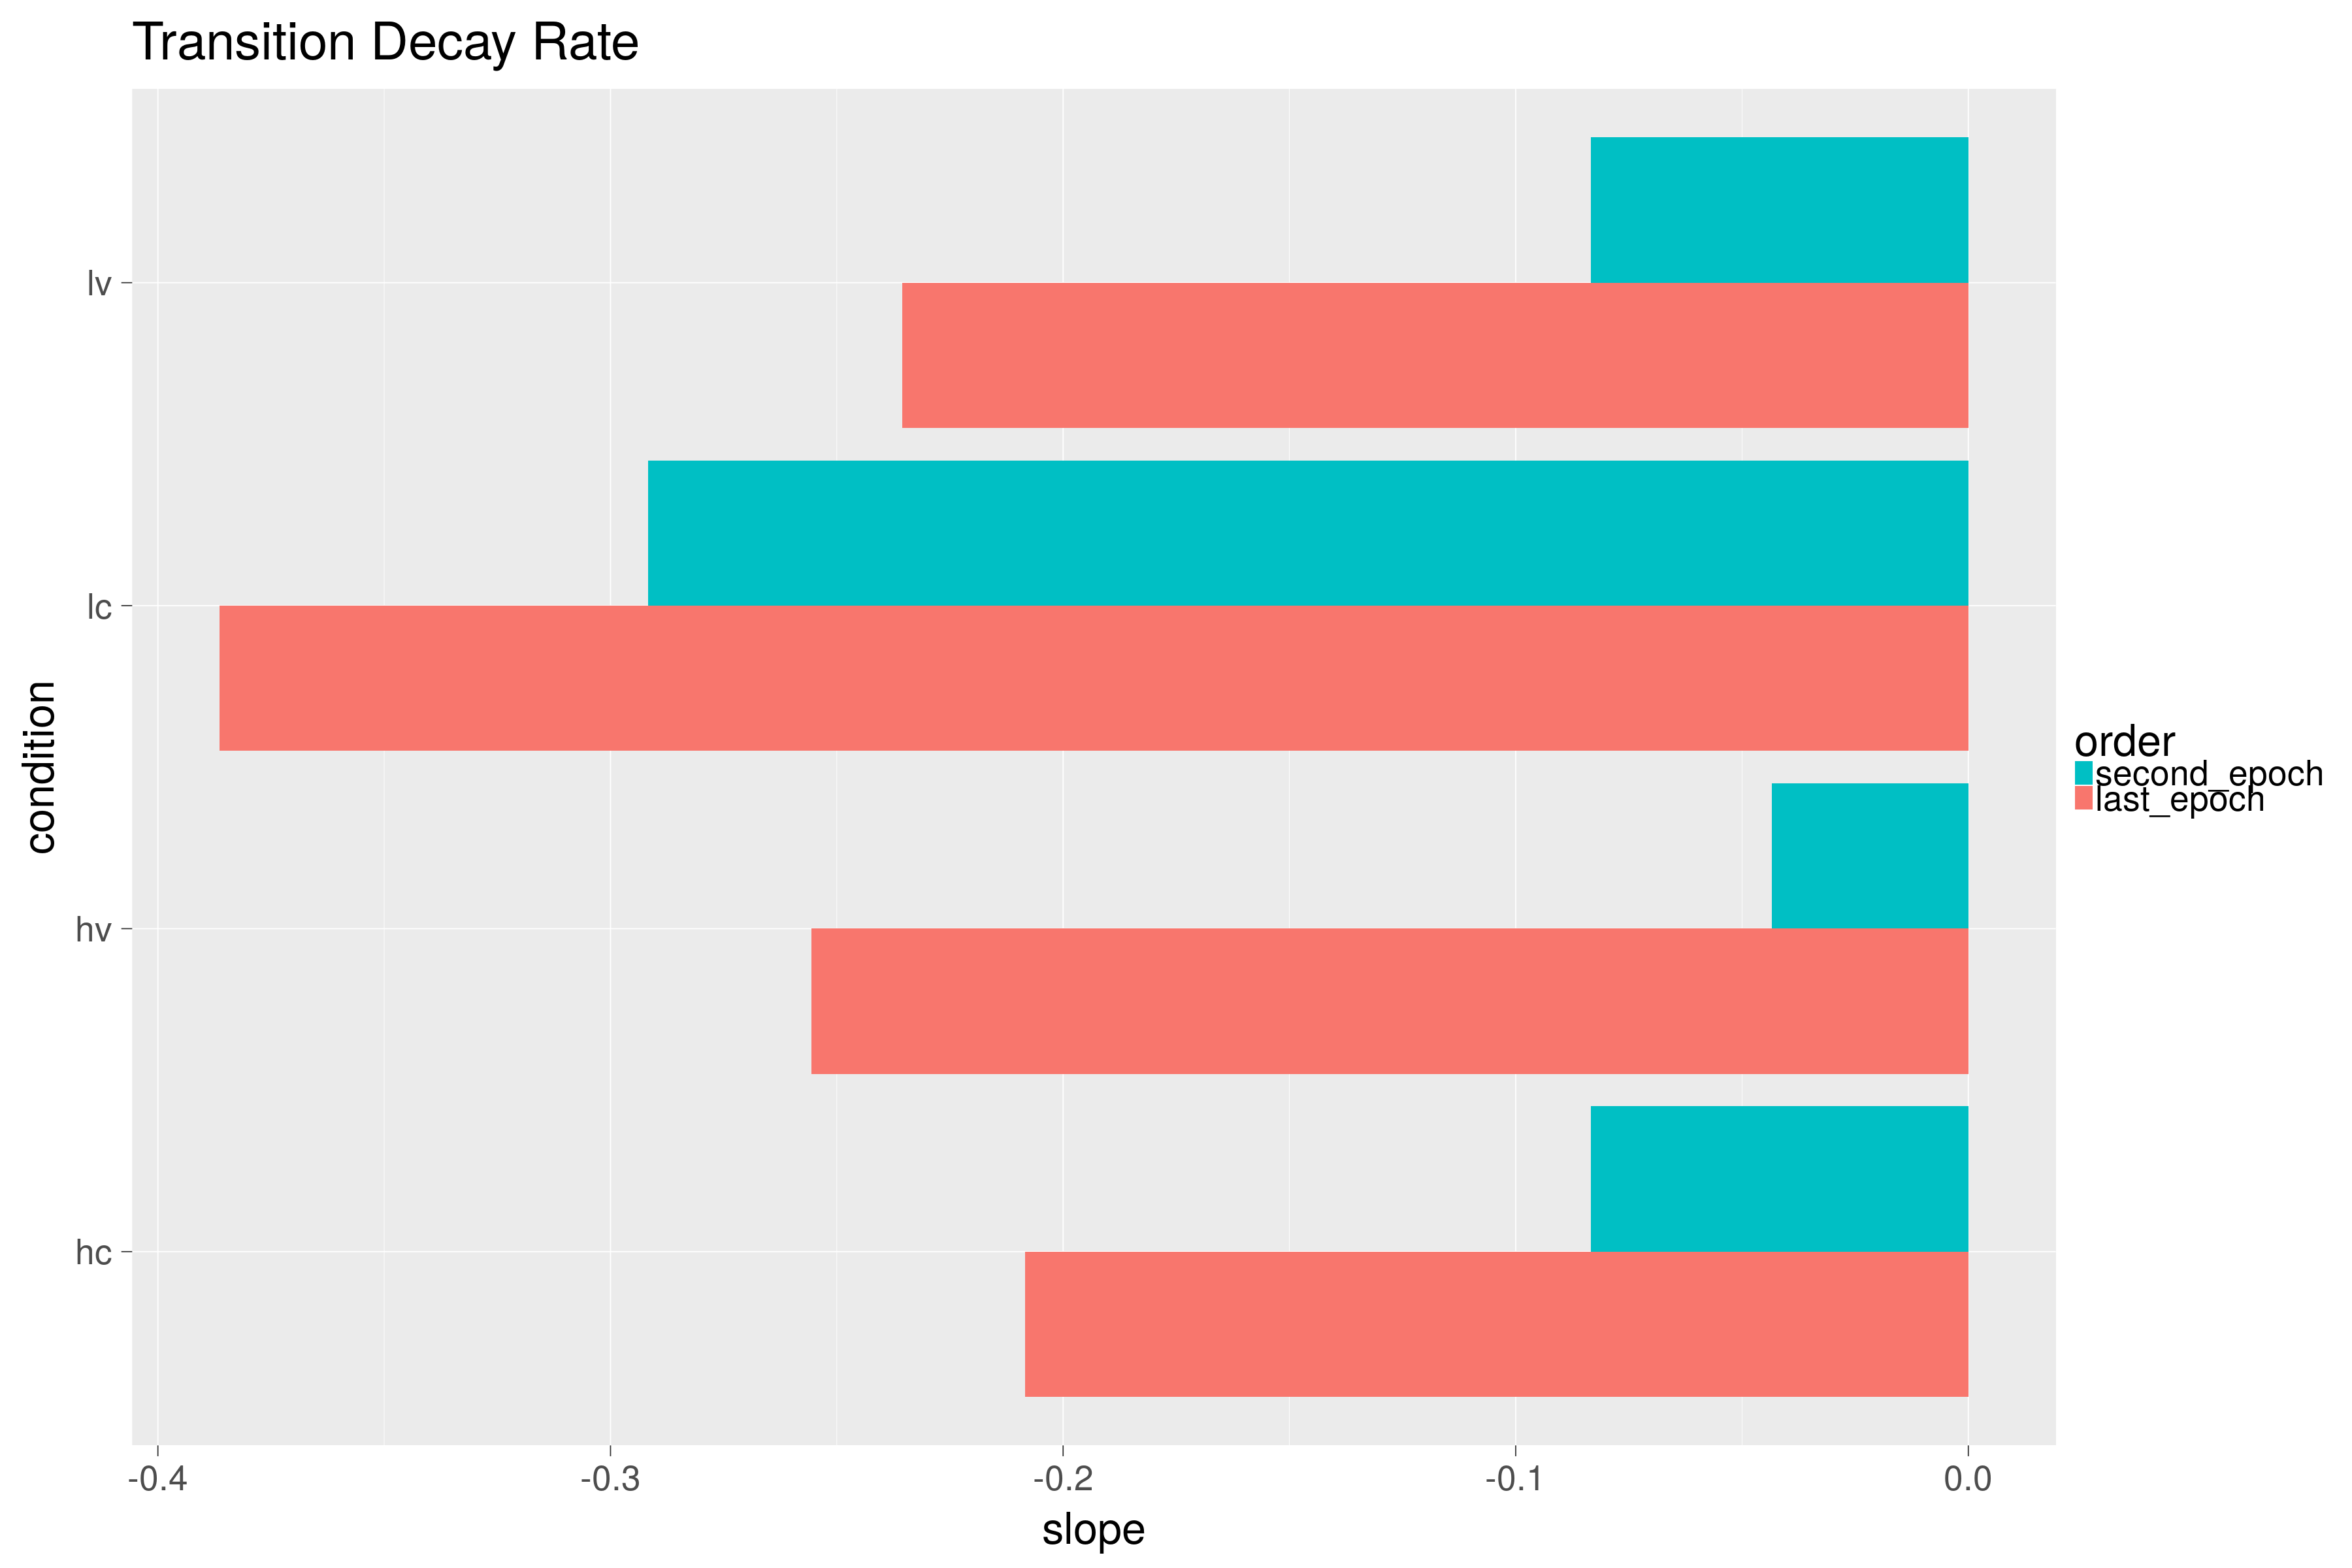

In [65]:
p<-ggplot(data=slopes_transition, aes(x=condition, y=slope,fill=order)) + geom_bar(stat='identity',position='dodge') +   ggtitle('Transition Decay Rate') 
p +  coord_flip() +  guides(fill = guide_legend(reverse = TRUE))
# + scale_fill_discrete(breaks=c('first', 'last'))

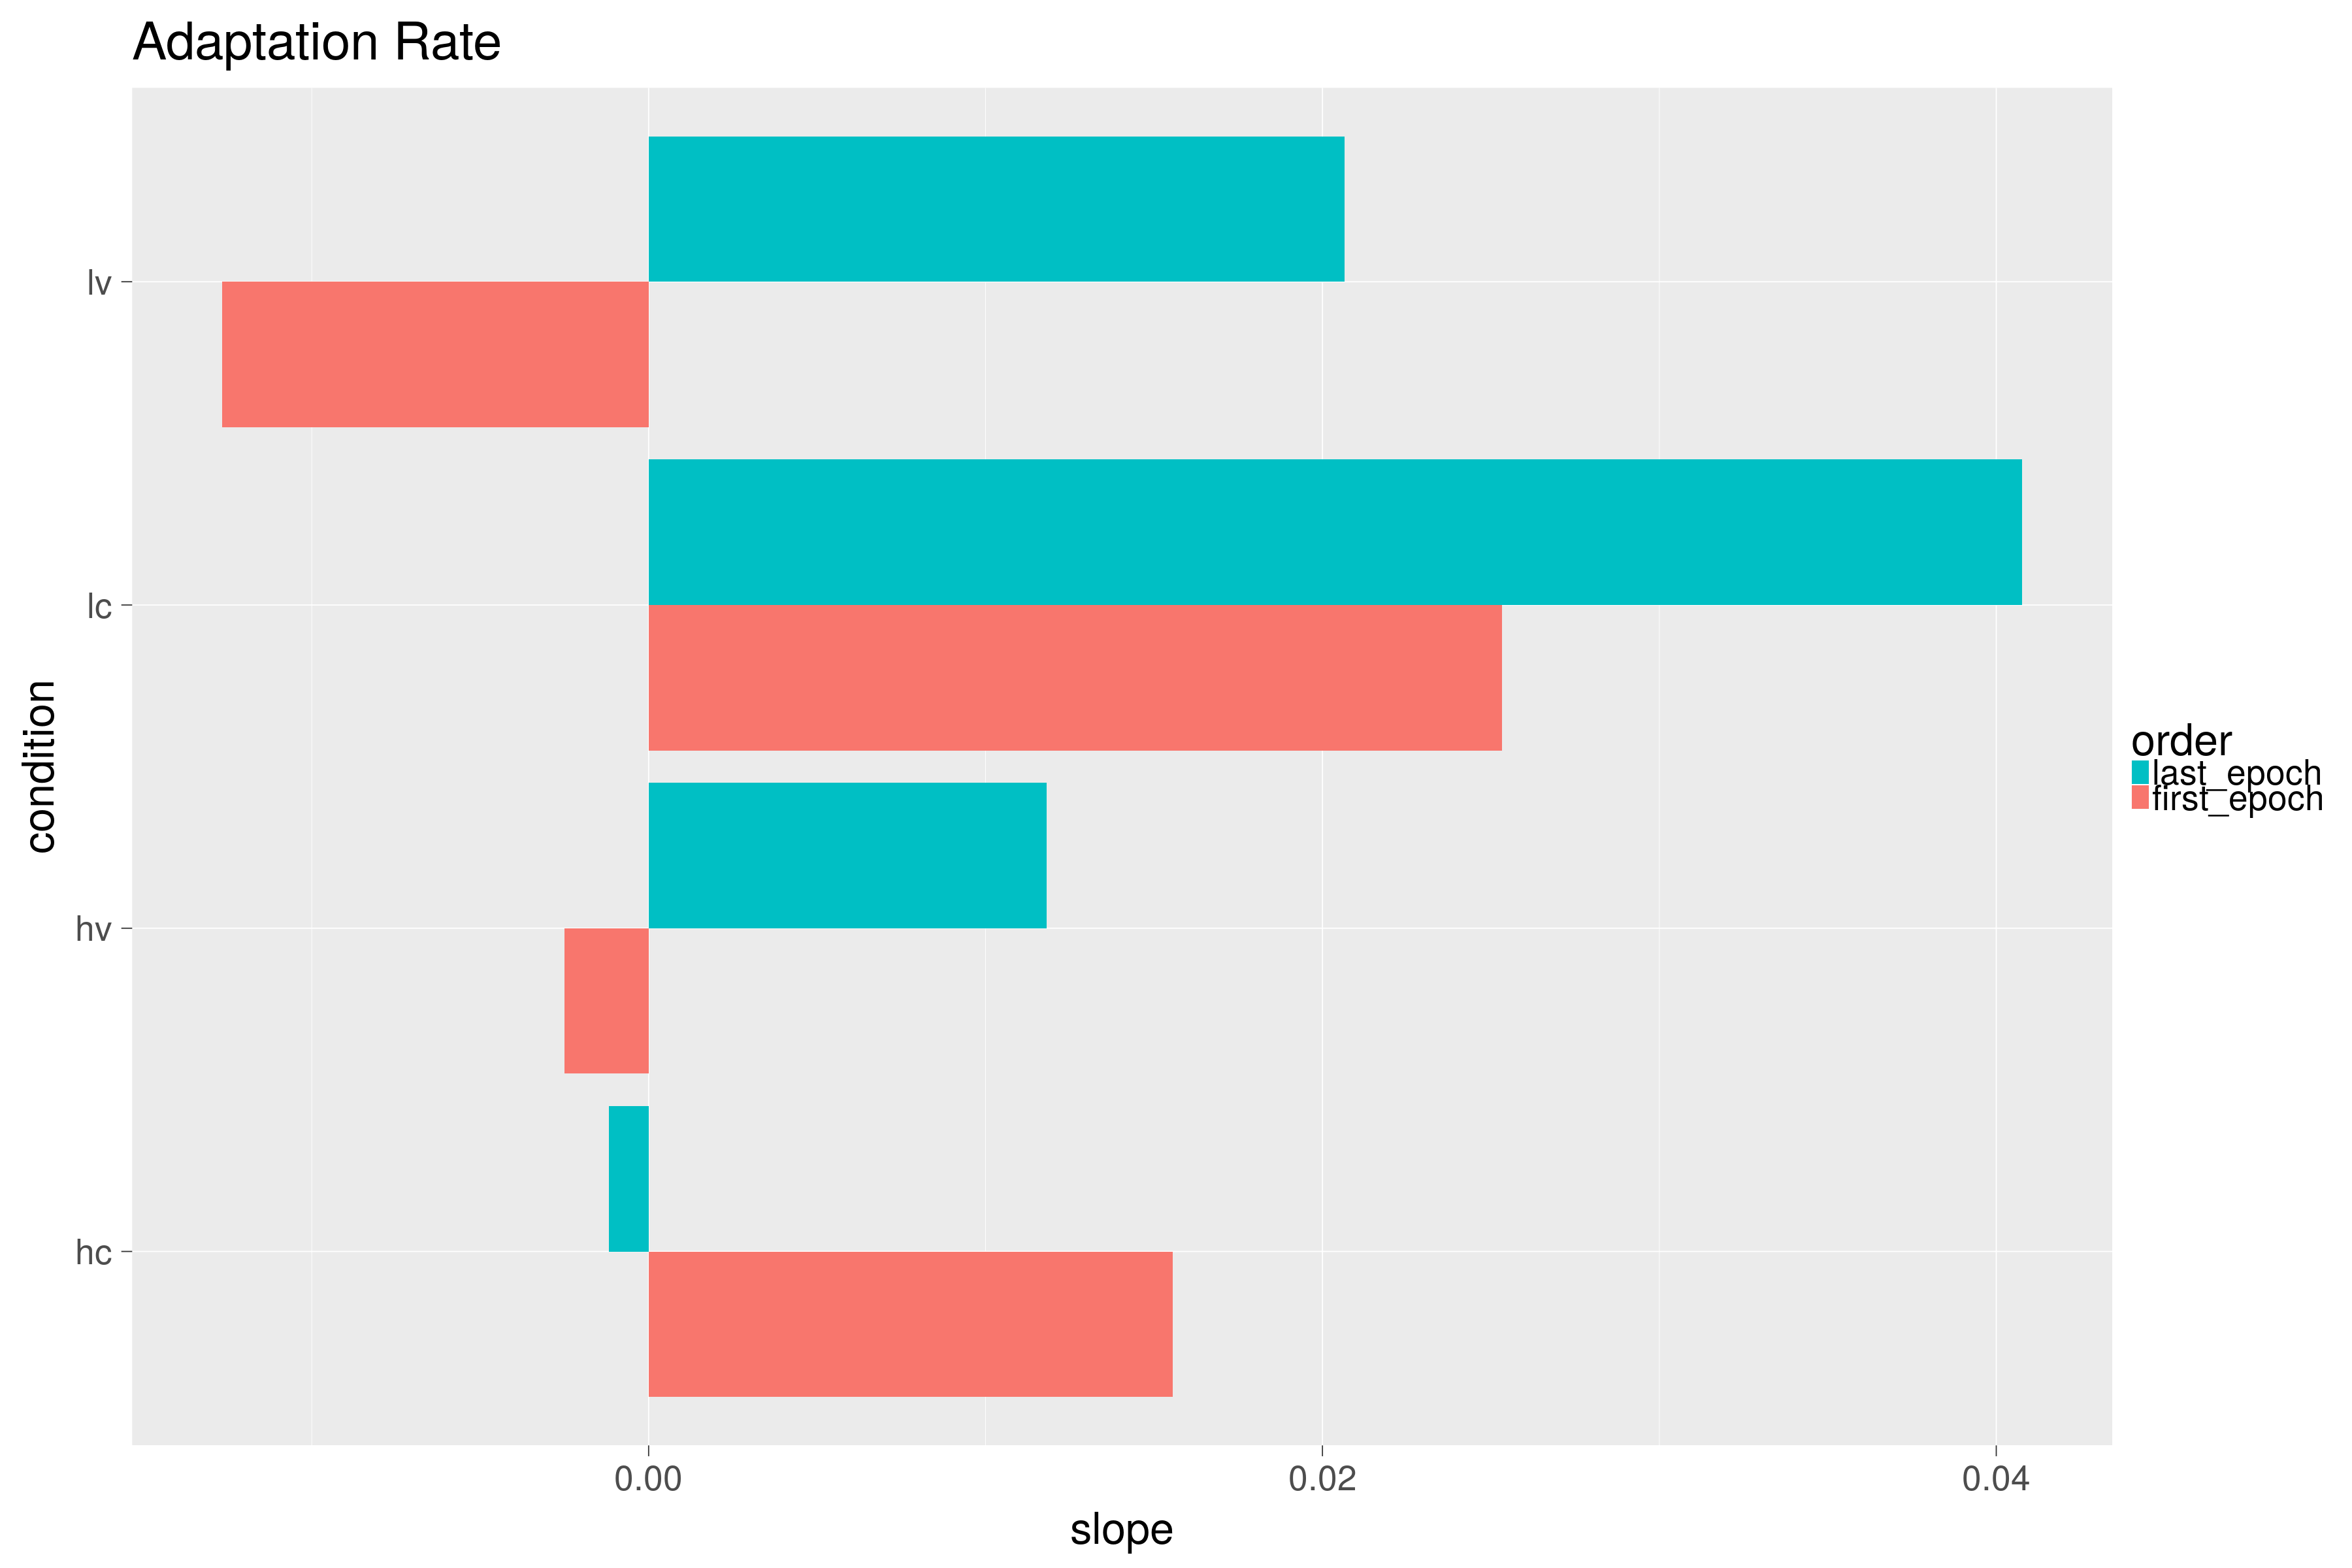

In [67]:
p<-ggplot(data=slopes_adaptation, aes(x=condition, y=slope,fill=order)) + geom_bar(stat='identity',position='dodge') +  
ggtitle('Adaptation Rate') 
        
                                
p + coord_flip() +  guides(fill = guide_legend(reverse = TRUE))
# + scale_fill_discrete(breaks=c('first', 'last'))

### assess variance by bootstrapping slopes 

In [103]:
data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'lc')

In [68]:
#going to need more data for transition decay rate, or bootstrap the accuracies themselves
library(boot)
slope <- function(formula, data, indices) {
  d <- data[indices,] 
  fit <- lm(formula, data=d)
  return(fit$coeff[2])
} 

lm_formula = mu_acc~shifted_epoch_trial



bs_lc_first_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'lc'), statistic=slope, 
  	R=1000, formula=lm_formula)
bs_lc_last_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 22 & condition == 'lc'), statistic=slope, 
  	R=1000, formula=lm_formula)

bs_hc_first_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'hc'), statistic=slope, 
  	R=1000, formula=lm_formula)
bs_hc_last_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 22 & condition == 'hc'), statistic=slope, 
  	R=1000, formula=lm_formula)


bs_hv_first_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'hv'), statistic=slope, 
  	R=1000, formula=lm_formula)
bs_hv_last_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 37 & condition == 'hv'), statistic=slope, 
  	R=1000, formula=lm_formula)

bs_lv_first_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 1 & condition == 'lv'), statistic=slope, 
  	R=1000, formula=lm_formula)
bs_lv_last_slopes <- boot(data=subset(epoch_rate_df_mu, adaptation_phase == 1 & epoch_n == 16 & condition == 'lv'), statistic=slope, 
  	R=1000, formula=lm_formula)

In [122]:
bootstrapped_slopes <- list(bs_hv_first_slopes, bs_hv_last_slopes, bs_lv_first_slopes, bs_lv_last_slopes,
    bs_hc_first_slopes, bs_hc_last_slopes,bs_lc_first_slopes, bs_lc_last_slopes)

In [138]:
boot_ci <-function(boot_object){
    boot.ci(boot_object, type = c("bca"))$bca[4:5]
}

In [183]:
(bootstrapped_slope_cis <- unlist(lapply(bootstrapped_slopes,boot_ci)))

(condition <- rep(c('hv','lv', 'hc', 'lc'), each = 2)
)

(order <- rep(c('first', 'last'), 4)
)# 
    
(ci <- rep(c('lower', 'upper'), 4)
)# 
bootstrapped_slope_cis_df <- data.frame(cbind(as.numeric(as.character(bootstrapped_slope_cis)), 
                                               condition, order, ci))
colnames(bootstrapped_slope_cis_df)[1]<- 'value'

bootstrapped_slope_cis_df



[1] -0.0250107229  0.0153000329 -0.0126093037  0.0341018153 -0.0347474188
 [6]  0.0072257236  0.0043150310  0.0297866299 -0.0046251475  0.0348991822
[11]  0.0001004864  0.0448207005  0.0013515084  0.0404334268  0.0115647422
[16]  0.0601581148

[1] "hv" "hv" "lv" "lv" "hc" "hc" "lc" "lc"

[1] "first" "last"  "first" "last"  "first" "last"  "first" "last"

[1] "lower" "upper" "lower" "upper" "lower" "upper" "lower" "upper"

value                condition order ci   
1  -0.0250107229041319  hv        first lower
2  0.0153000329348393   hv        last  upper
3  -0.0126093036871653  lv        first lower
4  0.0341018153420288   lv        last  upper
5  -0.0347474187757141  hc        first lower
6  0.00722572360716882  hc        last  upper
7  0.00431503096323413  lc        first lower
8  0.0297866298721886   lc        last  upper
9  -0.00462514745926649 hv        first lower
10 0.0348991821993551   hv        last  upper
11 0.000100486367350928 lv        first lower
12 0.0448207004510693   lv        last  upper
13 0.00135150841835425  hc        first lower
14 0.0404334268371621   hc        last  upper
15 0.0115647422255229   lc        first lower
16 0.0601581148038365   lc        last  upper

In [184]:
bs_slope_dists<-rbind(bs_lc_first_slopes$t, bs_lc_last_slopes$t, 
                 bs_lv_first_slopes$t,
                 bs_lv_last_slopes$t,bs_hv_first_slopes$t,
                 bs_hv_last_slopes$t,bs_hc_first_slopes$t,
                 bs_hc_last_slopes$t)
condition <- rep(c('lc','lv', 'hv', 'hc'),each=2000)
order <- rep(c('first','last'),each=1000, times=8)

bs_adaptation_slopes_df<-data.frame(bs_slope_dists, condition, order)

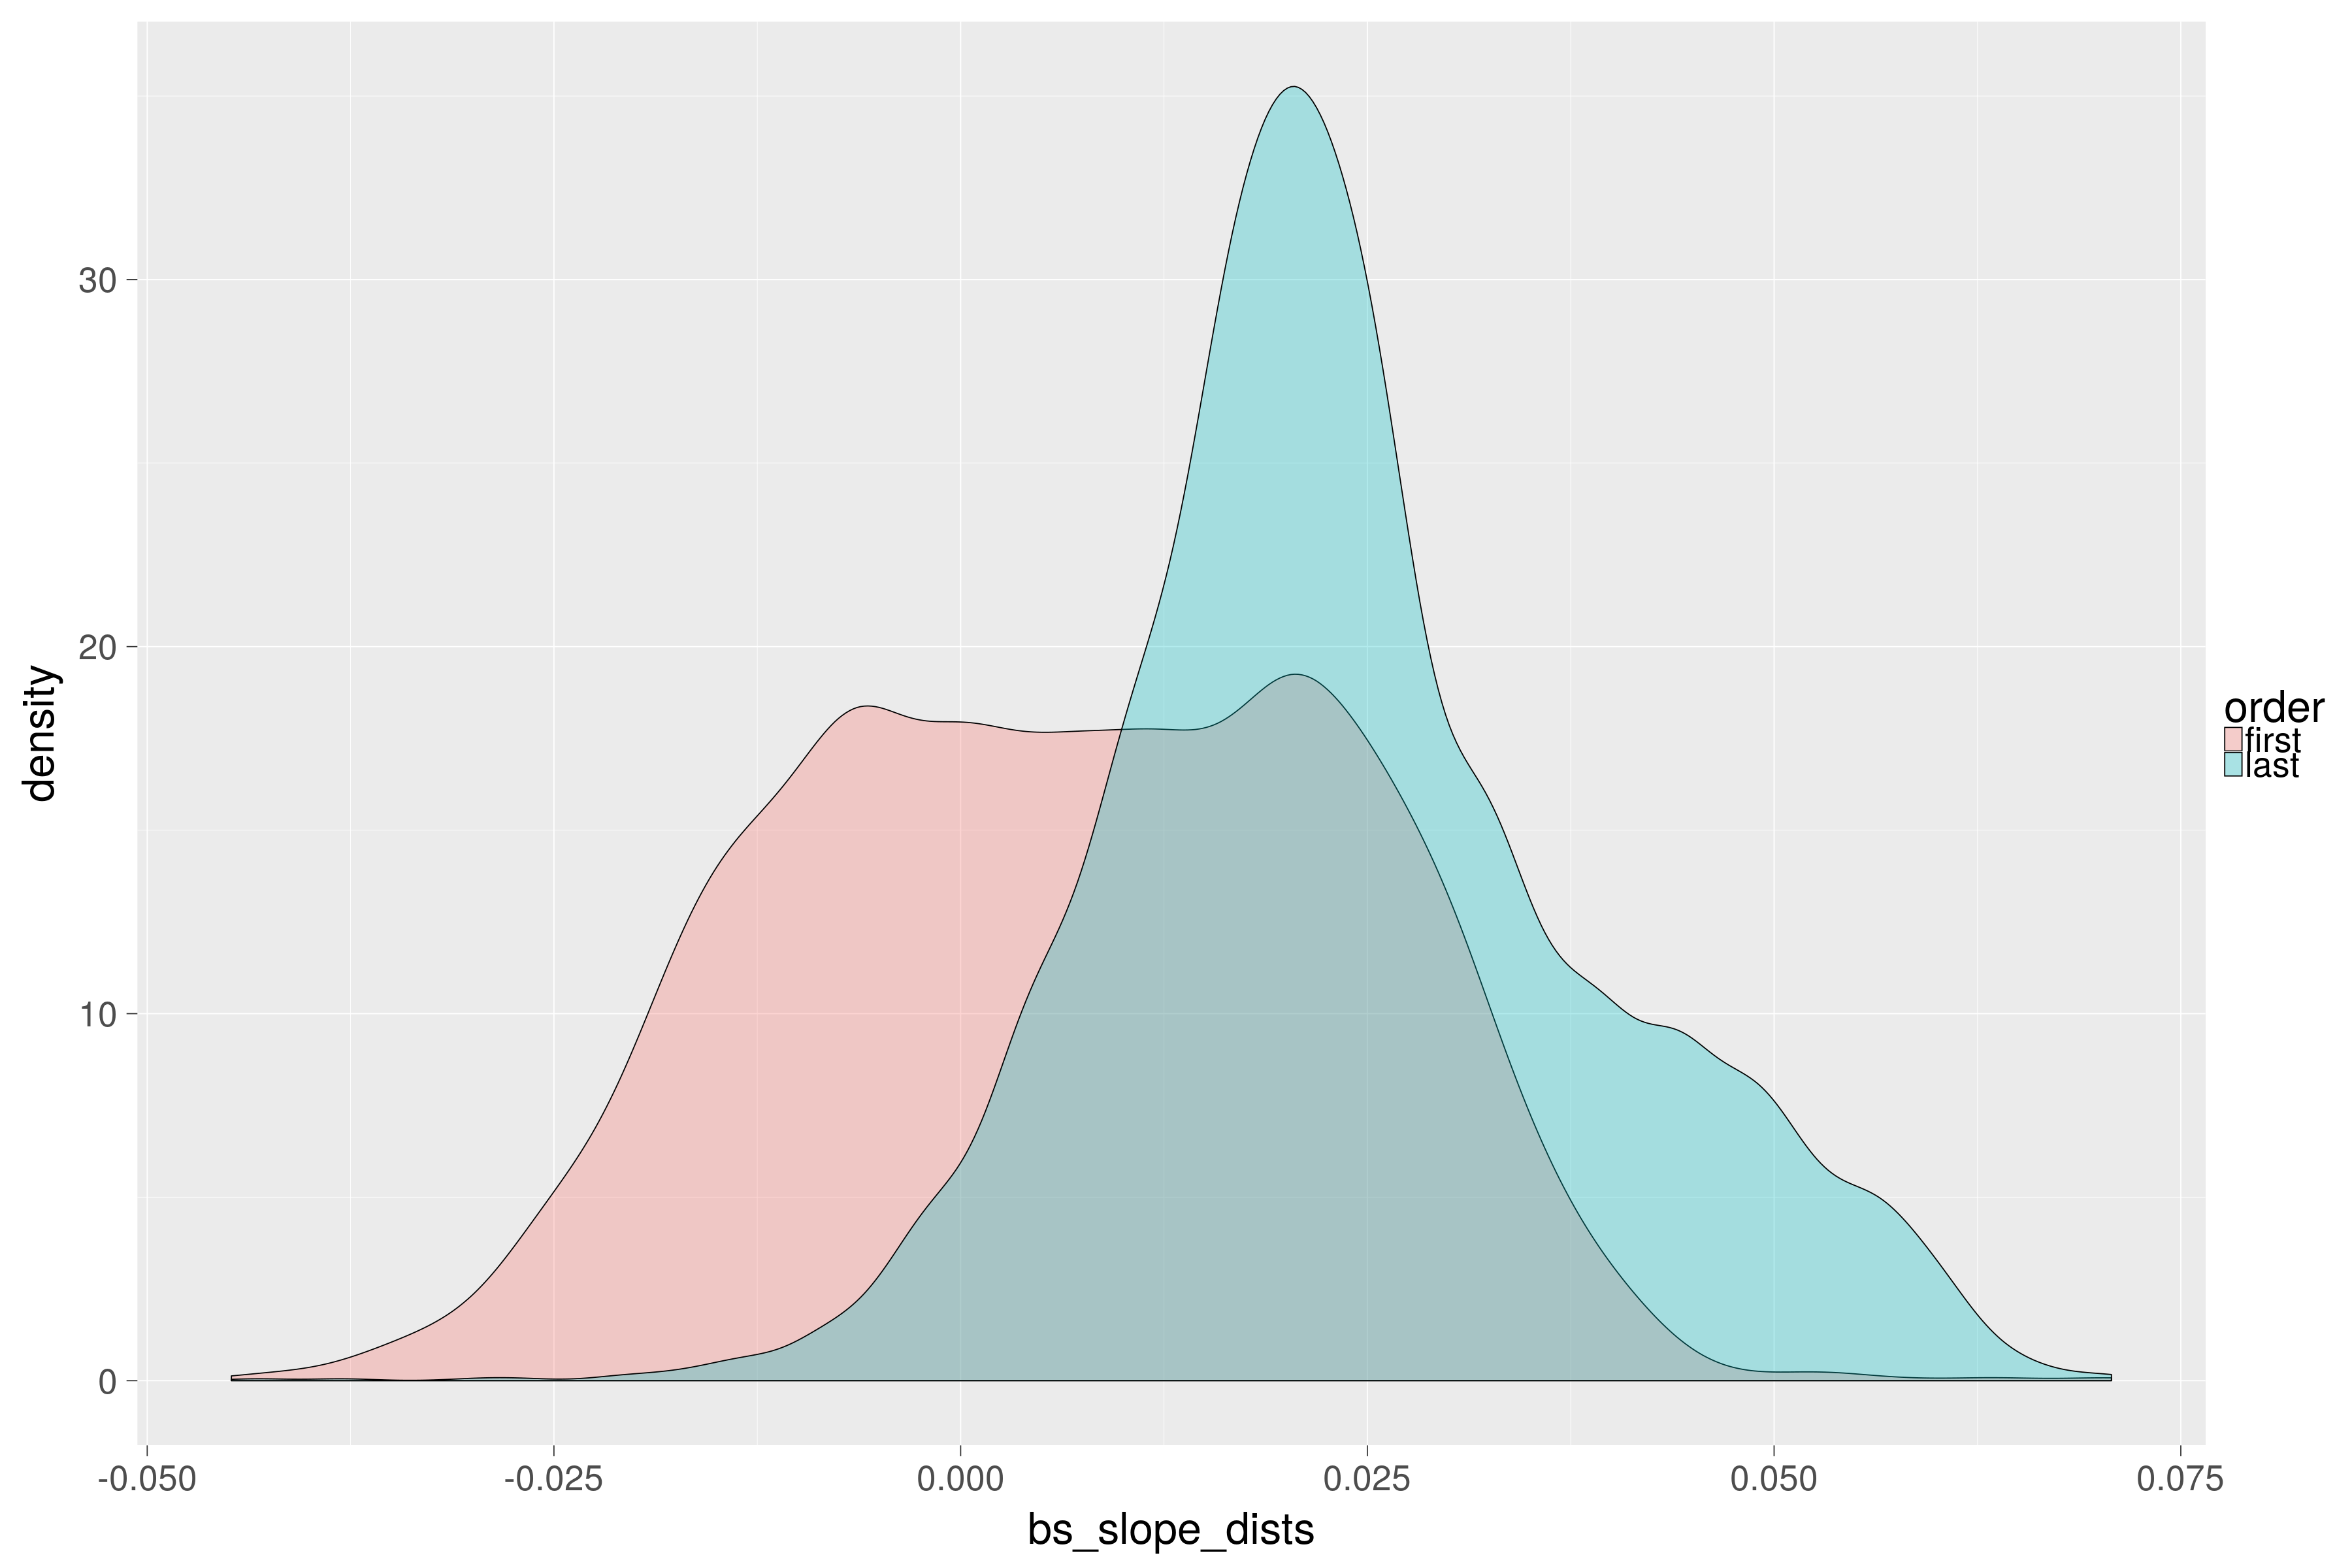

In [185]:
bs_slopes_density_plt<-ggplot(data=bs_adaptation_slopes_df, aes(x=bs_slope_dists,fill=order)) +
   geom_density(alpha=0.3)  
bs_slopes_density_plt            

In [192]:
bootstrapped_slope_cis_df

value                condition order ci   
1  -0.0250107229041319  hv        first lower
2  0.0153000329348393   hv        last  upper
3  -0.0126093036871653  lv        first lower
4  0.0341018153420288   lv        last  upper
5  -0.0347474187757141  hc        first lower
6  0.00722572360716882  hc        last  upper
7  0.00431503096323413  lc        first lower
8  0.0297866298721886   lc        last  upper
9  -0.00462514745926649 hv        first lower
10 0.0348991821993551   hv        last  upper
11 0.000100486367350928 lv        first lower
12 0.0448207004510693   lv        last  upper
13 0.00135150841835425  hc        first lower
14 0.0404334268371621   hc        last  upper
15 0.0115647422255229   lc        first lower
16 0.0601581148038365   lc        last  upper

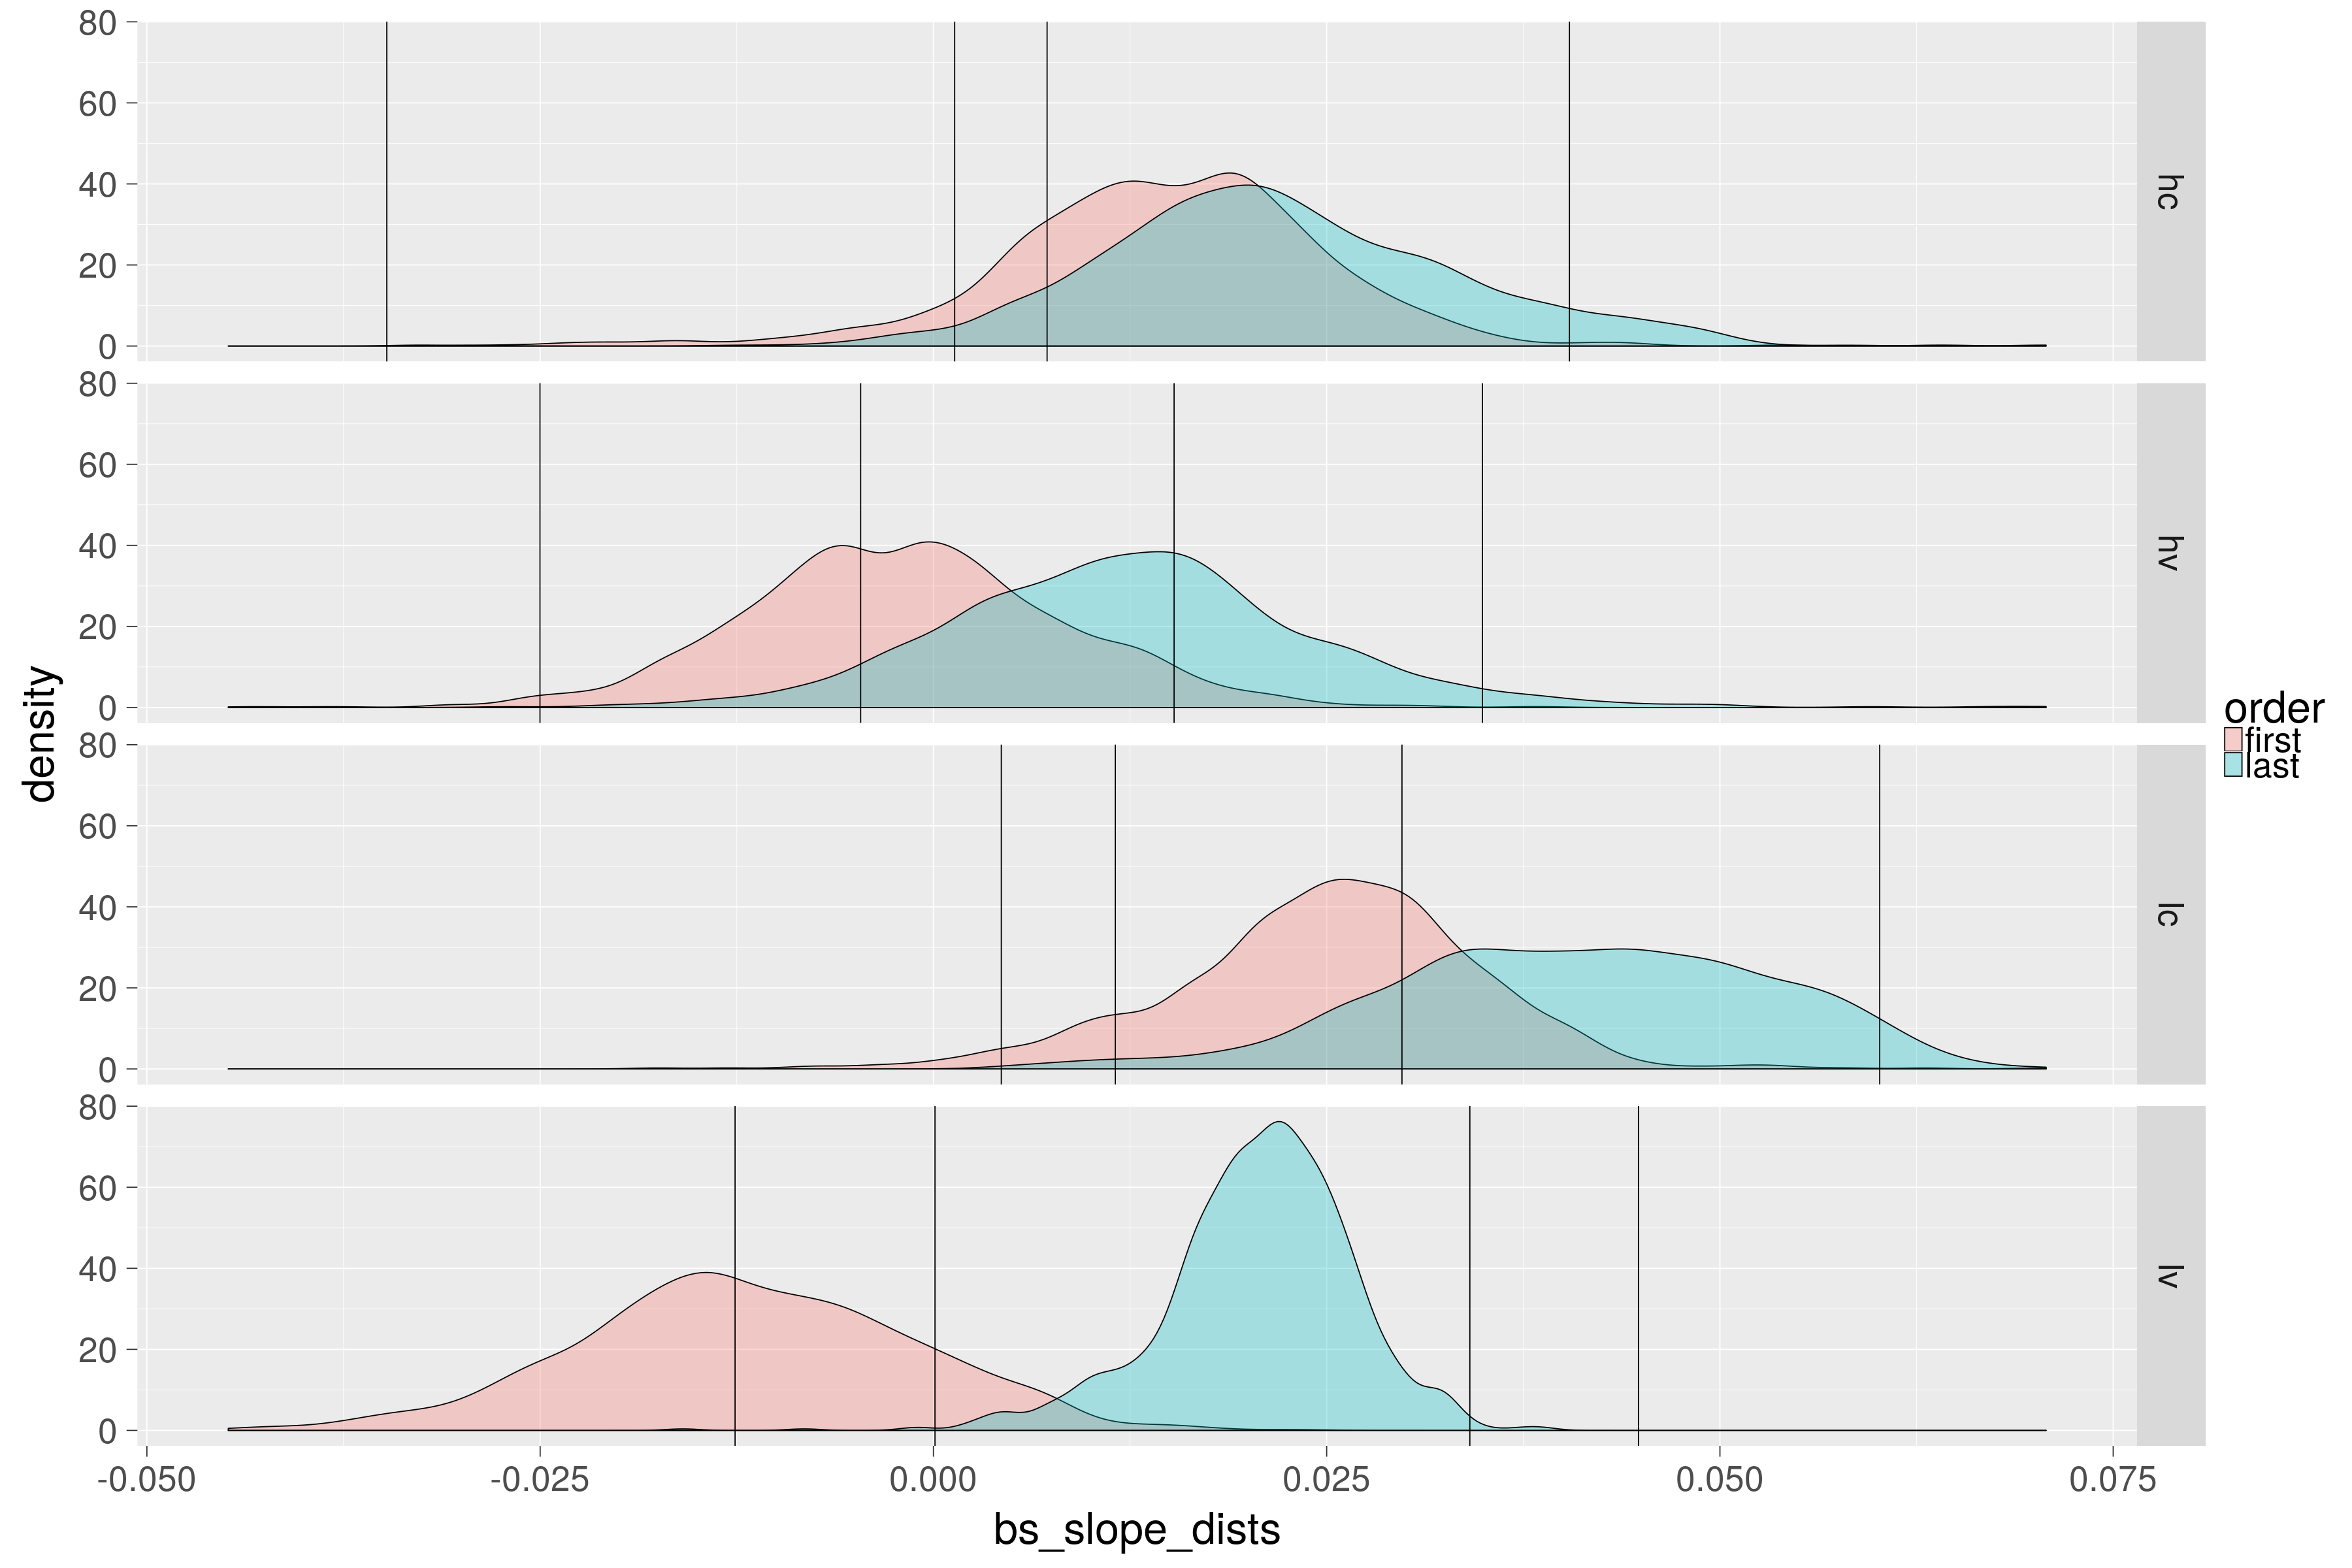

In [196]:
bs_slopes_density_plt + geom_vline(aes(xintercept=as.numeric(as.character(value))), data=bootstrapped_slope_cis_df) +
facet_grid(condition~.)  

# geom_vline(xintercept=intercept_boot_ci$perc[4:5], linetype='dashed', color='red') 

In [108]:
bs_adapt_plt <- ggplot(bs_adaptation_slopes_df, aes(condition, bs_slope_dists, fill=order)) + stat_summary(fun.y = "mean", geom = "bar", size=2, position='dodge' )  +  
stat_summary(fun.data = "mean_cl_boot", geom = "errorbar", position=position_dodge(width=0.95), size=1) + ggtitle('Adaptation Rate') 

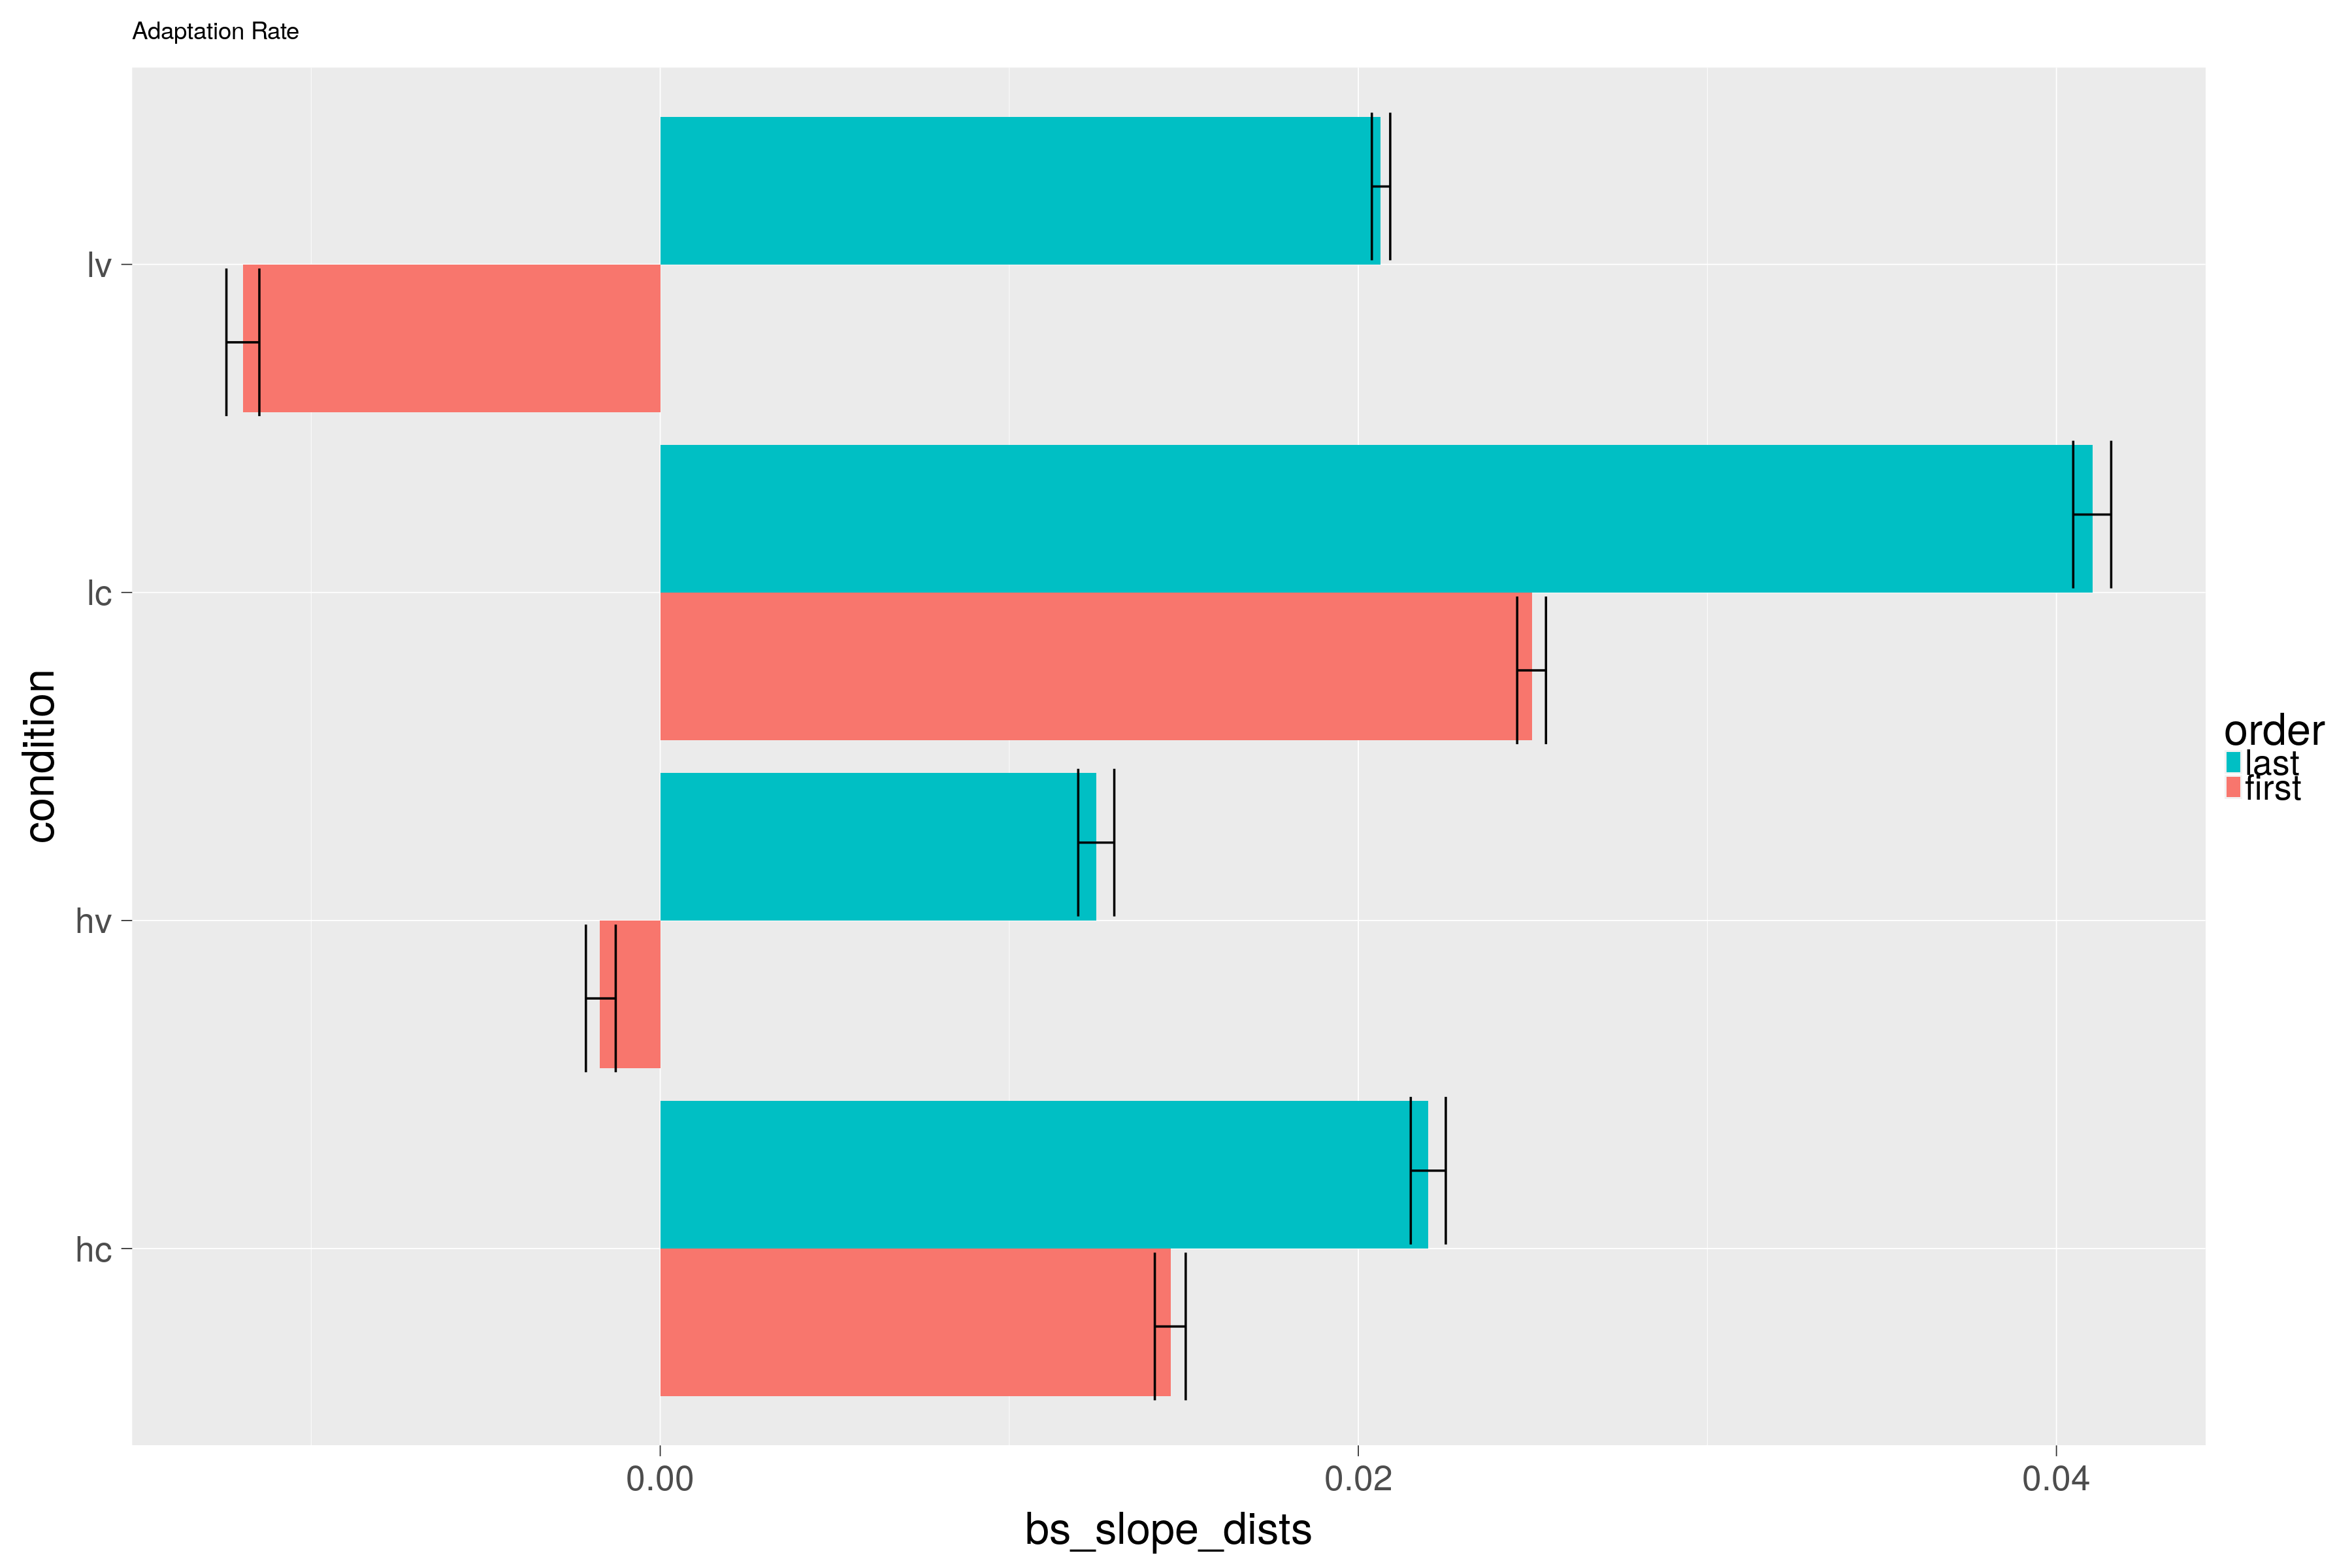

In [109]:
bs_adapt_plt + theme(plot.title = element_text(size=22)) + coord_flip() +  guides(fill = guide_legend(reverse = TRUE))